## Evaluation

In [1]:
%matplotlib inline

In [2]:
import warnings
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import pickle
import os
import copy
from glob import glob
from lxml import etree
import pickle
from fastprogress import progress_bar
import time

import sys
import tensorflow as tf

sys.path.append("/home/jossalgon/notebooks/VICTORY/deepknowledge/models/research/")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

np.random.seed(42)

In [3]:
CLASSES = ['Handgun','Rifle']
# CLASSES = ['Handgun']
DATASET_PATH = 'C:/Users/JHChen/Downloads/Images'
# DATASET_PATH = '/media/Shared/jossalgon/weapons/datasets/weapons/weapons-detector/HR_images/HR_imfdb_splited/'
# DATASET_PATH = '/media/Shared/jossalgon/weapons/datasets/weapons/weapons-detector/3000/'
TEST_IMAGE_PATHS = [ os.path.join(DATASET_PATH, file) for file in os.listdir(DATASET_PATH) if file.endswith('.jpg') ]
TEST_ANNOTATION_PATHS = [ os.path.join(DATASET_PATH, file) for file in os.listdir(DATASET_PATH) if file.endswith('.xml') ]

MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
# PICKLE_PATH = os.path.join(MODEL_PATH, 'validx4-imfdb-splited.pkl')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_PATH, 'frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(MODELS_PATH, MODEL_NAME, 'output/labelmap.pbtxt')
CKPT_NUM = 100000
IMAGE_SIZE = (12, 8)

## Tensorflow utils

In [4]:
def load_image_into_numpy_array(image):
    return np.asarray(image).astype(np.uint8)

In [5]:
def run_inference_for_single_image(sess, image, graph):
    # Get handles to input and output tensors
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detection_masks'
    ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                    tensor_name)
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
                detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
            'detection_classes'][0].astype(np.int64)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'Handgun'}, 2: {'id': 2, 'name': 'Rifle'}}

In [7]:
category_names = {ci['name']:ci['id'] for ci in category_index.values()}
category_names

{'Handgun': 1, 'Rifle': 2}

## Generate detections

Load the frozen Tensorflow model into memory

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

Loading label map

In [9]:
# This is needed to display the images.
%matplotlib inline

In [10]:
def get_detections(num_images=None, visualize=False):
    detections = []
    
    with tf.Session(graph=detection_graph) as sess:       
        for filename in progress_bar(TEST_ANNOTATION_PATHS[:num_images]):
            xml_file = etree.parse(filename)
            image_filename = xml_file.find('filename').text
            if image_filename[:3] is not '.jpg':
                image_filename += '.jpg'

            gt_classes, gt_bboxes = [], []
            for dobject in xml_file.findall('object'):
                class_name = dobject.find('name').text
                bbox = dobject.find('bndbox')
                if class_name in category_names:
                    gt_classes.append(category_names[class_name] )
#                     gt_bboxes.append([float(value.text)*4 for value in bbox.getchildren()])
                    gt_bboxes.append([float(value.text) for value in bbox.getchildren()])

            image_path = os.path.join(os.path.dirname(filename), image_filename)
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(sess, image_np_expanded, detection_graph)
            
            detection_boxes = get_detection_boxes_from_normalized(image, output_dict['detection_boxes'])

            detection = {
                'file': os.path.basename(image_path),
                'gt_classes': gt_classes,
                'gt_bboxes': gt_bboxes,
                'pred_classes': output_dict['detection_classes'],
                'pred_bboxes': detection_boxes,
                'file_path': image_path,
                'confidences': output_dict['detection_scores']
            }
            detections.append(detection)

            # Visualization of the results of a detection.
            if visualize:
                # GT visualization
                draw = ImageDraw.Draw(image)
                for gt_bbox in gt_bboxes:
                    print('GT: ', gt_bbox)
                    draw.rectangle([gt_bbox[0], gt_bbox[1], gt_bbox[2], gt_bbox[3]], outline='green', width=10)
                
                for i in range(len(detection_boxes)):
                    if output_dict['detection_scores'][i] > 0.5:
                        detection_box = detection_boxes[i]
                        print('PRED: ',detection_box)
                        draw.rectangle([detection_box[0], detection_box[1], detection_box[2], detection_box[3]], outline='red', width=10)

                image_np = load_image_into_numpy_array(image)  
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)
        return detections

In [11]:
def get_detection_boxes_from_normalized(image, norm_dbboxes):
    dbboxes = []
    im_width, im_height = image.size
    
    for bbox in norm_dbboxes:
        ymin, xmin, ymax, xmax = bbox
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
        dbboxes.append([left, top, right, bottom])
    return dbboxes

GT:  [4252.561983471074, 2828.8861689106484, 4480.0, 3056.25458996328]
GT:  [4183.801652892562, 565.7772337821298, 4289.586776859504, 692.6805385556916]
PRED:  [4244.194793701172, 2831.0129928588867, 4497.979431152344, 3027.9908180236816]
PRED:  [4186.773834228516, 572.1872162818909, 4279.825286865234, 683.8565039634705]
GT:  [4569.917355371901, 2765.434516523868, 4739.173553719009, 3093.268053855569]
PRED:  [4576.889190673828, 2757.333698272705, 4752.381591796875, 3088.736801147461]
GT:  [4355.702479338843, 602.7906976744185, 4461.487603305785, 766.7074663402692]
PRED:  [4308.335723876953, 2640.0939559936523, 4482.998199462891, 3047.5427055358887]
PRED:  [4347.963409423828, 630.2236104011536, 4445.992126464844, 759.9459886550903]
PRED:  [4302.890167236328, 2356.916027069092, 4471.222686767578, 3113.1470489501953]


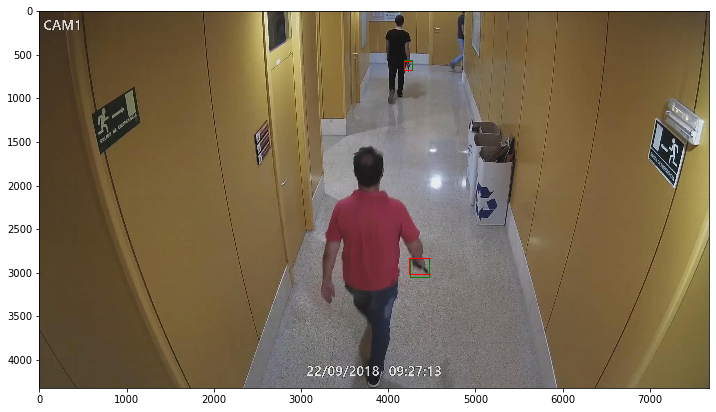

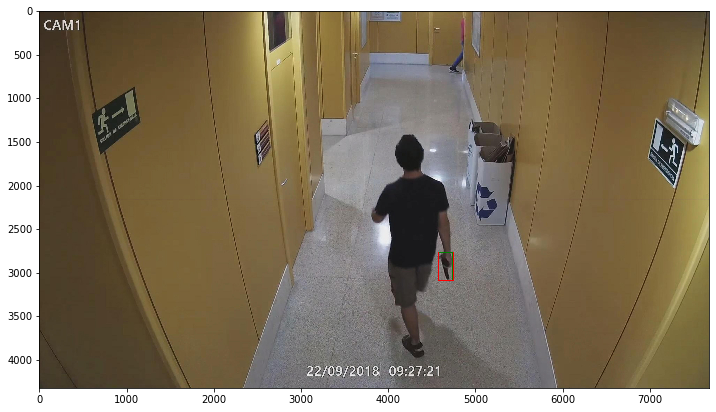

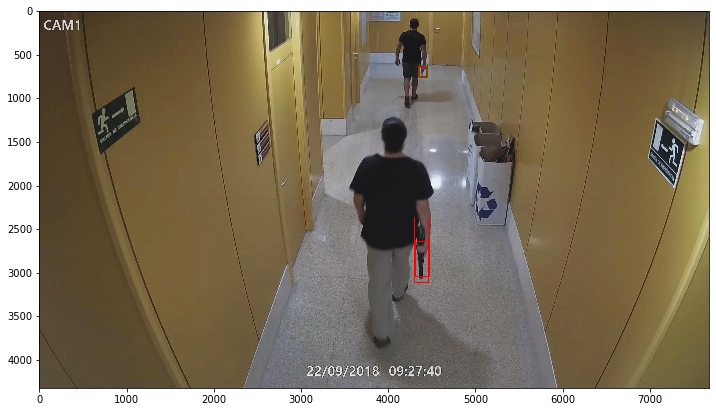

In [12]:
detections = get_detections(3, visualize=True);

In [13]:
detections[0]

{'file': 'Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg',
 'gt_classes': [1, 1],
 'gt_bboxes': [[4252.561983471074,
   2828.8861689106484,
   4480.0,
   3056.25458996328],
  [4183.801652892562,
   565.7772337821298,
   4289.586776859504,
   692.6805385556916]],
 'pred_classes': array([1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
        2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2,
        2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
        1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
detections = get_detections()

In [15]:
with open(PICKLE_PATH, 'wb') as pickle_file:
    pickle.dump(detections, pickle_file)

In [16]:
from numba import cuda
cuda.select_device(0)
cuda.close()

## Load detection results

In [11]:
with open(PICKLE_PATH, 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

## Utils

In [17]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [18]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [19]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [20]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [21]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [22]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [23]:
MIN_ACC = 0.2
OUR_IMAGE_AREA = 1920*1080
COCO_IMAGE_AREA = 600*600
S_AREA_LIMIT = 32**2*OUR_IMAGE_AREA/COCO_IMAGE_AREA
M_AREA_LIMIT = 96**2*OUR_IMAGE_AREA/COCO_IMAGE_AREA

def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5, print_info=False):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    if print_info:
        print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    pred_bboxes = {'S': 0, 'M': 0, 'L': 0}
    n_pred_bboxes = 0
    gt_bboxes = {'S': 0, 'M': 0, 'L': 0}
    n_gt_bboxes = 0
    
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
                
                BBGT_area = (BBGT[0][2] - BBGT[0][0])*(BBGT[0][3] - BBGT[0][1])
                if BBGT_area <= S_AREA_LIMIT:
                    gt_bboxes['S'] += 1
                elif BBGT_area <= M_AREA_LIMIT:
                    gt_bboxes['M'] +=1
                else:
                    gt_bboxes['L'] +=1
                
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if -1 * sorted_scores[d] > MIN_ACC:
            if ioumax > iouthresh:
                if not gt_info['detected?'][jmax]:
                    tp[d] = 1. # true positive
                    gt_info['detected?'][jmax] = 1
                    avg_overlap.append(ioumax)
                    
                    BBGT_area = (BBGT[0][2] - BBGT[0][0])*(BBGT[0][3] - BBGT[0][1])
                    n_pred_bboxes += 1
                    if BBGT_area <= S_AREA_LIMIT:
                        pred_bboxes['S'] += 1
                    elif BBGT_area <= M_AREA_LIMIT:
                        pred_bboxes['M'] +=1
                    else:
                        pred_bboxes['L'] +=1
                else:
                    fp[d] = 1. # false positive (multiple detection)
            else:
                fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    class_name = category_index[cls]['name']

    if print_info:
        print("TP: {}".format(tp[-1]))
        print("FP: {}".format(fp[-1]))
        print("FN: {}".format(fn))
        print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
        print("Predicted bounding boxes: small -> {}, medium -> {}, large -> {}, total -> {}".format(pred_bboxes['S'], pred_bboxes['M'], pred_bboxes['L'], n_pred_bboxes))
        print("GT bounding boxes: small -> {}, medium -> {}, large -> {}, total -> {}".format(gt_bboxes['S'], gt_bboxes['M'], gt_bboxes['L'], n_gt_bboxes))
        print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
        print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [24]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [25]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
#     plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [26]:
def compute_mean_average_precision(detections, print_info=True):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            if print_info:
                print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    if print_info:
        print('Mean AP = {:.4f}'.format(np.mean(aps)))
        print('~~~~~~~~')
        print('Results:')
        print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [27]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in category_index.values():
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)

#         iouthresh = 0.5
#         rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
#         if ap is not None:
#             aps_iou += [ap]
#             print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
#         plot_precision_recall(prec, rec, ap)
        
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

def compute_mean_average_precision_COCO2016_noplot(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in category_index.values():
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh, print_info=False)
            if ap is not None:
                aps_iou += [ap]
#                 print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
#             plot_precision_recall(prec, rec, ap)

#         iouthresh = 0.5
#         rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
#         if ap is not None:
#             aps_iou += [ap]
#             print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
#         plot_precision_recall(prec, rec, ap)
        
        aps_class += [np.mean(aps_iou)] 
#         print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
#     print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
#     print('~~~~~~~~')
#     print('Results:')
#     for ap in aps_class:
#         print('{:.3f}'.format(ap))
#     print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return aps_class, mAP

## Model MAPs

## mAPs Cam 1

In [45]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'

### Only lab - 0k unity

In [48]:
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 71.0
FP: 23.0
FN: 189.0
Avg. overlap for Handgun = 0.7277
Predicted bounding boxes: small -> 66, medium -> 5, large -> 0, total -> 71
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.7553
Recall for Handgun = 0.2731
AP for Handgun and IoU threshold 0.50 = 0.2406


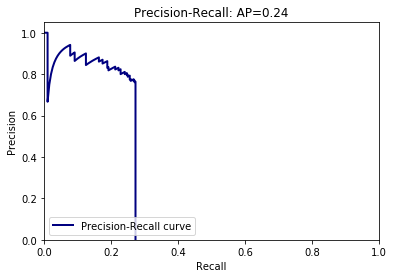

IoU threshold set to: 0.55
TP: 67.0
FP: 27.0
FN: 193.0
Avg. overlap for Handgun = 0.7394
Predicted bounding boxes: small -> 62, medium -> 5, large -> 0, total -> 67
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.7128
Recall for Handgun = 0.2577
AP for Handgun and IoU threshold 0.55 = 0.2272


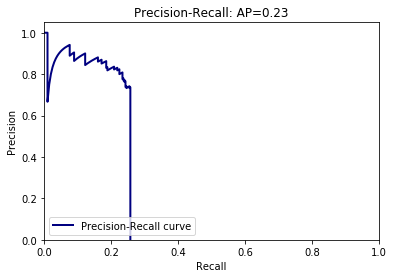

IoU threshold set to: 0.60
TP: 67.0
FP: 27.0
FN: 193.0
Avg. overlap for Handgun = 0.7394
Predicted bounding boxes: small -> 62, medium -> 5, large -> 0, total -> 67
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.7128
Recall for Handgun = 0.2577
AP for Handgun and IoU threshold 0.60 = 0.2272


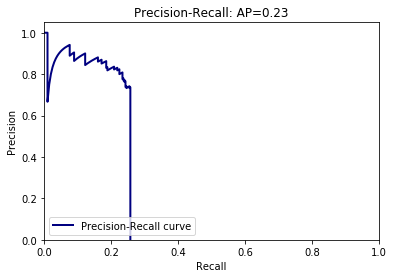

IoU threshold set to: 0.65
TP: 53.0
FP: 41.0
FN: 207.0
Avg. overlap for Handgun = 0.7682
Predicted bounding boxes: small -> 49, medium -> 4, large -> 0, total -> 53
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5638
Recall for Handgun = 0.2038
AP for Handgun and IoU threshold 0.65 = 0.1576


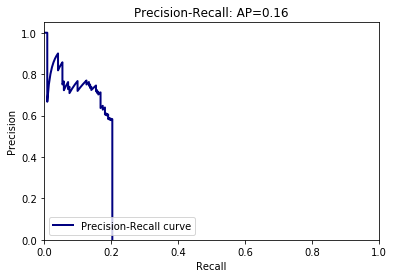

IoU threshold set to: 0.70
TP: 43.0
FP: 51.0
FN: 217.0
Avg. overlap for Handgun = 0.7889
Predicted bounding boxes: small -> 40, medium -> 3, large -> 0, total -> 43
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4574
Recall for Handgun = 0.1654
AP for Handgun and IoU threshold 0.70 = 0.1119


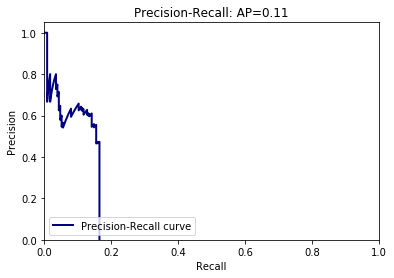

IoU threshold set to: 0.75
TP: 33.0
FP: 61.0
FN: 227.0
Avg. overlap for Handgun = 0.8079
Predicted bounding boxes: small -> 31, medium -> 2, large -> 0, total -> 33
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.3511
Recall for Handgun = 0.1269
AP for Handgun and IoU threshold 0.75 = 0.0683


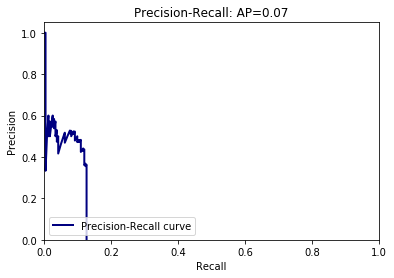

IoU threshold set to: 0.80
TP: 18.0
FP: 76.0
FN: 242.0
Avg. overlap for Handgun = 0.8400
Predicted bounding boxes: small -> 17, medium -> 1, large -> 0, total -> 18
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1915
Recall for Handgun = 0.0692
AP for Handgun and IoU threshold 0.80 = 0.0328


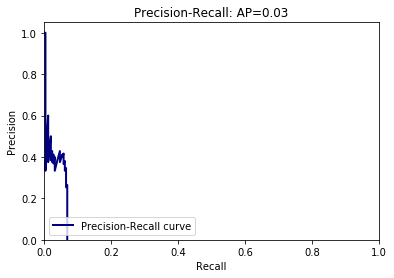

IoU threshold set to: 0.85
TP: 7.0
FP: 87.0
FN: 253.0
Avg. overlap for Handgun = 0.8708
Predicted bounding boxes: small -> 6, medium -> 1, large -> 0, total -> 7
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0745
Recall for Handgun = 0.0269
AP for Handgun and IoU threshold 0.85 = 0.0049


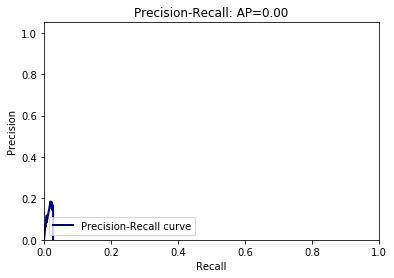

IoU threshold set to: 0.90
TP: 1.0
FP: 93.0
FN: 259.0
Avg. overlap for Handgun = 0.9025
Predicted bounding boxes: small -> 1, medium -> 0, large -> 0, total -> 1
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0106
Recall for Handgun = 0.0038
AP for Handgun and IoU threshold 0.90 = 0.0001


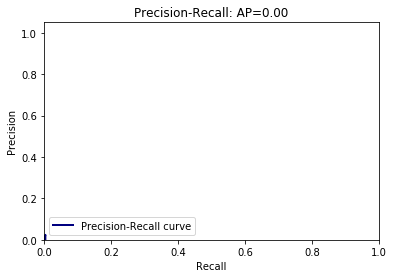

IoU threshold set to: 0.95
TP: 0.0
FP: 94.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


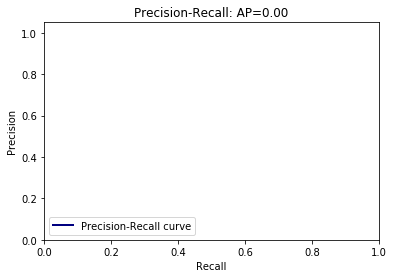

Mean AP for Handgun = 0.1071
IoU threshold set to: 0.50
TP: 64.0
FP: 7.0
FN: 156.0
Avg. overlap for Rifle = 0.7099
Predicted bounding boxes: small -> 36, medium -> 28, large -> 0, total -> 64
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.9014
Recall for Rifle = 0.2909
AP for Rifle and IoU threshold 0.50 = 0.2870


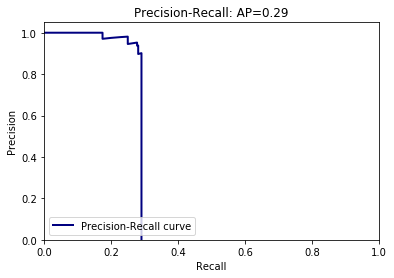

IoU threshold set to: 0.55
TP: 59.0
FP: 12.0
FN: 161.0
Avg. overlap for Rifle = 0.7256
Predicted bounding boxes: small -> 32, medium -> 27, large -> 0, total -> 59
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8310
Recall for Rifle = 0.2682
AP for Rifle and IoU threshold 0.55 = 0.2550


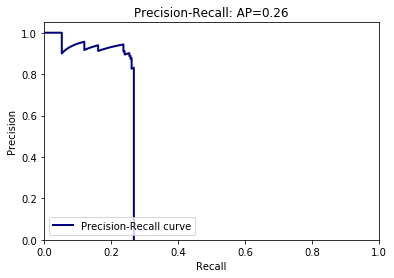

IoU threshold set to: 0.60
TP: 54.0
FP: 17.0
FN: 166.0
Avg. overlap for Rifle = 0.7394
Predicted bounding boxes: small -> 29, medium -> 25, large -> 0, total -> 54
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7606
Recall for Rifle = 0.2455
AP for Rifle and IoU threshold 0.60 = 0.2214


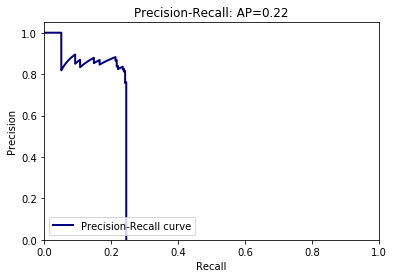

IoU threshold set to: 0.65
TP: 49.0
FP: 22.0
FN: 171.0
Avg. overlap for Rifle = 0.7510
Predicted bounding boxes: small -> 27, medium -> 22, large -> 0, total -> 49
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6901
Recall for Rifle = 0.2227
AP for Rifle and IoU threshold 0.65 = 0.1924


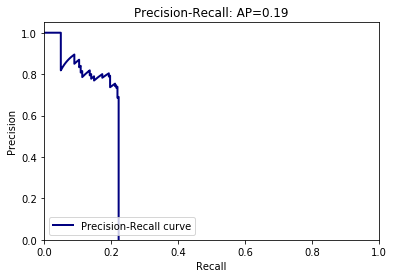

IoU threshold set to: 0.70
TP: 35.0
FP: 36.0
FN: 185.0
Avg. overlap for Rifle = 0.7794
Predicted bounding boxes: small -> 22, medium -> 13, large -> 0, total -> 35
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.4930
Recall for Rifle = 0.1591
AP for Rifle and IoU threshold 0.70 = 0.1235


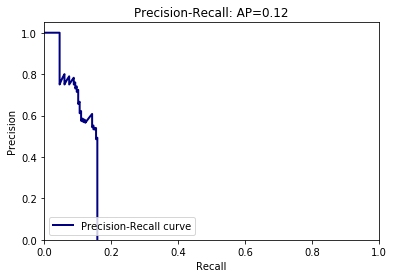

IoU threshold set to: 0.75
TP: 23.0
FP: 48.0
FN: 197.0
Avg. overlap for Rifle = 0.8059
Predicted bounding boxes: small -> 18, medium -> 5, large -> 0, total -> 23
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.3239
Recall for Rifle = 0.1045
AP for Rifle and IoU threshold 0.75 = 0.0694


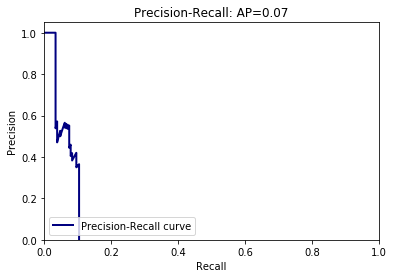

IoU threshold set to: 0.80
TP: 13.0
FP: 58.0
FN: 207.0
Avg. overlap for Rifle = 0.8329
Predicted bounding boxes: small -> 9, medium -> 4, large -> 0, total -> 13
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.1831
Recall for Rifle = 0.0591
AP for Rifle and IoU threshold 0.80 = 0.0315


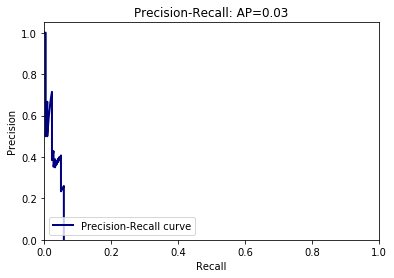

IoU threshold set to: 0.85
TP: 1.0
FP: 70.0
FN: 219.0
Avg. overlap for Rifle = 0.9084
Predicted bounding boxes: small -> 1, medium -> 0, large -> 0, total -> 1
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0141
Recall for Rifle = 0.0045
AP for Rifle and IoU threshold 0.85 = 0.0001


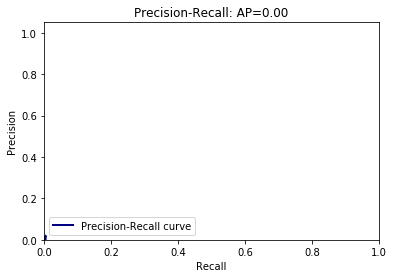

IoU threshold set to: 0.90
TP: 1.0
FP: 70.0
FN: 219.0
Avg. overlap for Rifle = 0.9084
Predicted bounding boxes: small -> 1, medium -> 0, large -> 0, total -> 1
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0141
Recall for Rifle = 0.0045
AP for Rifle and IoU threshold 0.90 = 0.0001


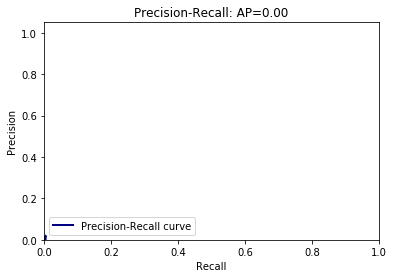

IoU threshold set to: 0.95
TP: 0.0
FP: 71.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


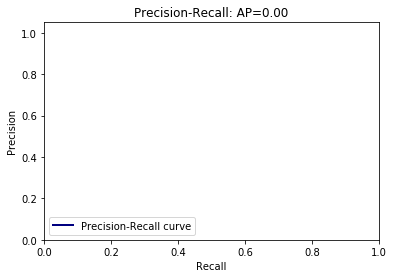

Mean AP for Rifle = 0.1180
Mean AP = 0.1125
~~~~~~~~
Results:
0.107
0.118
0.113


0.11254747018805855

In [49]:
compute_mean_average_precision_COCO2016(m0kunity_detections)

### Only lab - 1k unity

In [50]:
MODEL_NAME = 'weapons-onlylab-1kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 61.0
FP: 34.0
FN: 199.0
Avg. overlap for Handgun = 0.7482
Predicted bounding boxes: small -> 58, medium -> 3, large -> 0, total -> 61
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6421
Recall for Handgun = 0.2346
AP for Handgun and IoU threshold 0.50 = 0.2103


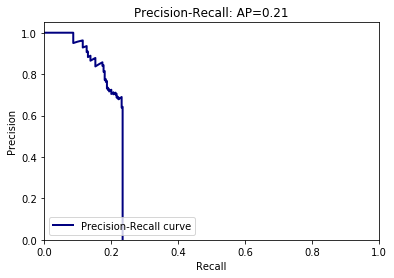

IoU threshold set to: 0.55
TP: 60.0
FP: 35.0
FN: 200.0
Avg. overlap for Handgun = 0.7523
Predicted bounding boxes: small -> 58, medium -> 2, large -> 0, total -> 60
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6316
Recall for Handgun = 0.2308
AP for Handgun and IoU threshold 0.55 = 0.2065


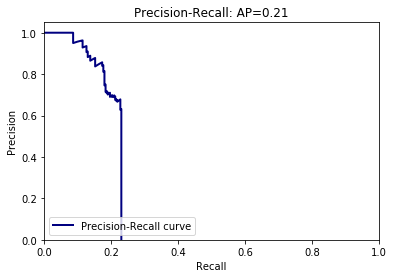

IoU threshold set to: 0.60
TP: 58.0
FP: 37.0
FN: 202.0
Avg. overlap for Handgun = 0.7584
Predicted bounding boxes: small -> 56, medium -> 2, large -> 0, total -> 58
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6105
Recall for Handgun = 0.2231
AP for Handgun and IoU threshold 0.60 = 0.1978


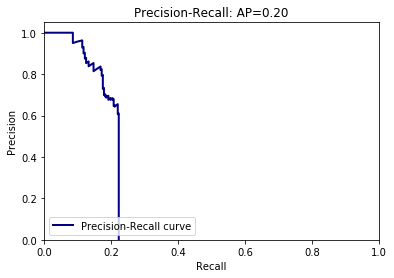

IoU threshold set to: 0.65
TP: 52.0
FP: 43.0
FN: 208.0
Avg. overlap for Handgun = 0.7735
Predicted bounding boxes: small -> 50, medium -> 2, large -> 0, total -> 52
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5474
Recall for Handgun = 0.2000
AP for Handgun and IoU threshold 0.65 = 0.1690


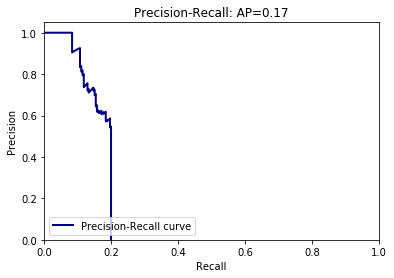

IoU threshold set to: 0.70
TP: 45.0
FP: 50.0
FN: 215.0
Avg. overlap for Handgun = 0.7902
Predicted bounding boxes: small -> 43, medium -> 2, large -> 0, total -> 45
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4737
Recall for Handgun = 0.1731
AP for Handgun and IoU threshold 0.70 = 0.1357


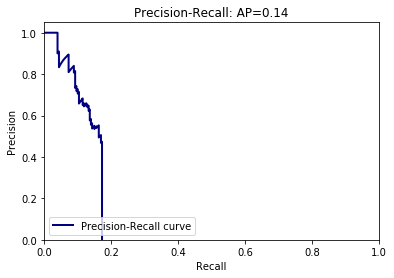

IoU threshold set to: 0.75
TP: 34.0
FP: 61.0
FN: 226.0
Avg. overlap for Handgun = 0.8116
Predicted bounding boxes: small -> 33, medium -> 1, large -> 0, total -> 34
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.3579
Recall for Handgun = 0.1308
AP for Handgun and IoU threshold 0.75 = 0.0936


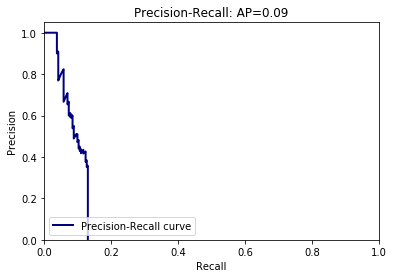

IoU threshold set to: 0.80
TP: 18.0
FP: 77.0
FN: 242.0
Avg. overlap for Handgun = 0.8490
Predicted bounding boxes: small -> 18, medium -> 0, large -> 0, total -> 18
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1895
Recall for Handgun = 0.0692
AP for Handgun and IoU threshold 0.80 = 0.0262


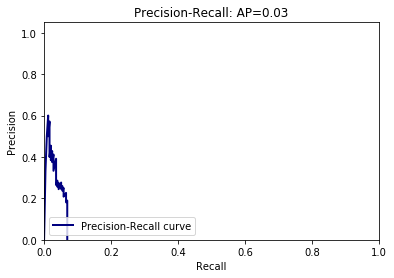

IoU threshold set to: 0.85
TP: 8.0
FP: 87.0
FN: 252.0
Avg. overlap for Handgun = 0.8771
Predicted bounding boxes: small -> 8, medium -> 0, large -> 0, total -> 8
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0842
Recall for Handgun = 0.0308
AP for Handgun and IoU threshold 0.85 = 0.0034


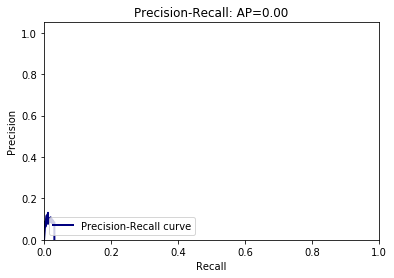

IoU threshold set to: 0.90
TP: 2.0
FP: 93.0
FN: 258.0
Avg. overlap for Handgun = 0.9070
Predicted bounding boxes: small -> 2, medium -> 0, large -> 0, total -> 2
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0211
Recall for Handgun = 0.0077
AP for Handgun and IoU threshold 0.90 = 0.0002


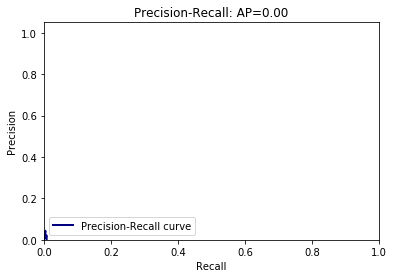

IoU threshold set to: 0.95
TP: 0.0
FP: 95.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


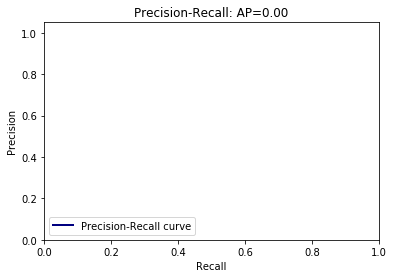

Mean AP for Handgun = 0.1043
IoU threshold set to: 0.50
TP: 58.0
FP: 13.0
FN: 162.0
Avg. overlap for Rifle = 0.7429
Predicted bounding boxes: small -> 30, medium -> 28, large -> 0, total -> 58
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8169
Recall for Rifle = 0.2636
AP for Rifle and IoU threshold 0.50 = 0.2470


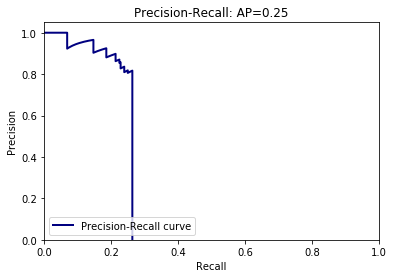

IoU threshold set to: 0.55
TP: 55.0
FP: 16.0
FN: 165.0
Avg. overlap for Rifle = 0.7551
Predicted bounding boxes: small -> 29, medium -> 26, large -> 0, total -> 55
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7746
Recall for Rifle = 0.2500
AP for Rifle and IoU threshold 0.55 = 0.2336


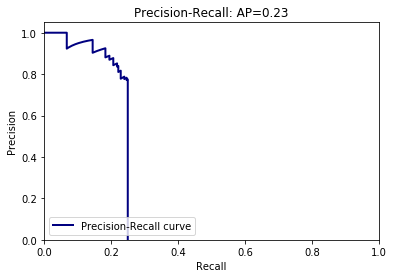

IoU threshold set to: 0.60
TP: 53.0
FP: 18.0
FN: 167.0
Avg. overlap for Rifle = 0.7623
Predicted bounding boxes: small -> 29, medium -> 24, large -> 0, total -> 53
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7465
Recall for Rifle = 0.2409
AP for Rifle and IoU threshold 0.60 = 0.2204


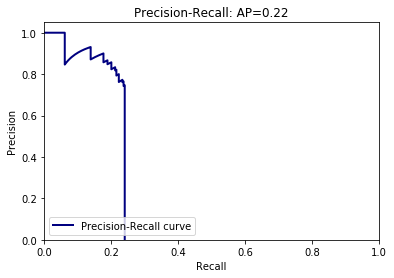

IoU threshold set to: 0.65
TP: 49.0
FP: 22.0
FN: 171.0
Avg. overlap for Rifle = 0.7738
Predicted bounding boxes: small -> 26, medium -> 23, large -> 0, total -> 49
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6901
Recall for Rifle = 0.2227
AP for Rifle and IoU threshold 0.65 = 0.1897


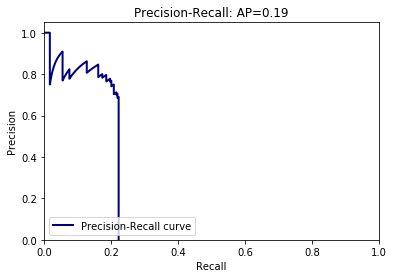

IoU threshold set to: 0.70
TP: 42.0
FP: 29.0
FN: 178.0
Avg. overlap for Rifle = 0.7895
Predicted bounding boxes: small -> 22, medium -> 20, large -> 0, total -> 42
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.5915
Recall for Rifle = 0.1909
AP for Rifle and IoU threshold 0.70 = 0.1307


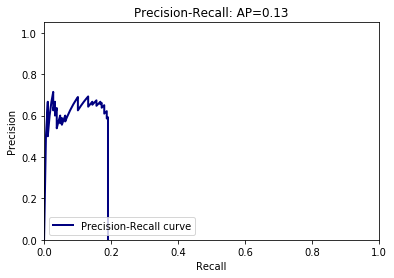

IoU threshold set to: 0.75
TP: 32.0
FP: 39.0
FN: 188.0
Avg. overlap for Rifle = 0.8114
Predicted bounding boxes: small -> 16, medium -> 16, large -> 0, total -> 32
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.4507
Recall for Rifle = 0.1455
AP for Rifle and IoU threshold 0.75 = 0.0807


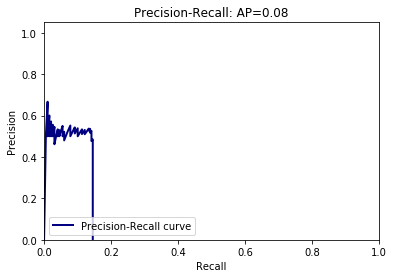

IoU threshold set to: 0.80
TP: 19.0
FP: 52.0
FN: 201.0
Avg. overlap for Rifle = 0.8417
Predicted bounding boxes: small -> 11, medium -> 8, large -> 0, total -> 19
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.2676
Recall for Rifle = 0.0864
AP for Rifle and IoU threshold 0.80 = 0.0424


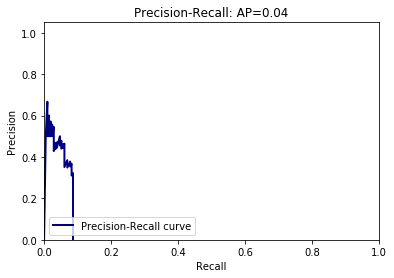

IoU threshold set to: 0.85
TP: 7.0
FP: 64.0
FN: 213.0
Avg. overlap for Rifle = 0.8739
Predicted bounding boxes: small -> 3, medium -> 4, large -> 0, total -> 7
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0986
Recall for Rifle = 0.0318
AP for Rifle and IoU threshold 0.85 = 0.0074


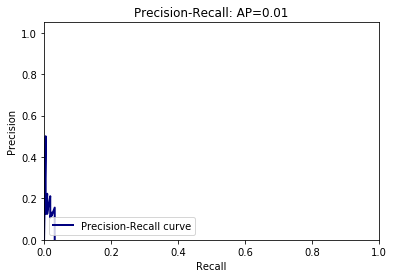

IoU threshold set to: 0.90
TP: 1.0
FP: 70.0
FN: 219.0
Avg. overlap for Rifle = 0.9353
Predicted bounding boxes: small -> 1, medium -> 0, large -> 0, total -> 1
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0141
Recall for Rifle = 0.0045
AP for Rifle and IoU threshold 0.90 = 0.0003


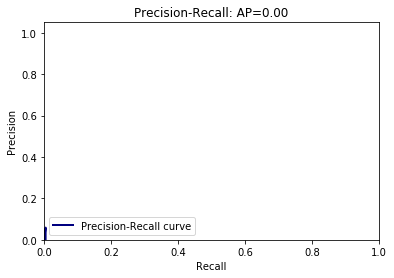

IoU threshold set to: 0.95
TP: 0.0
FP: 71.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


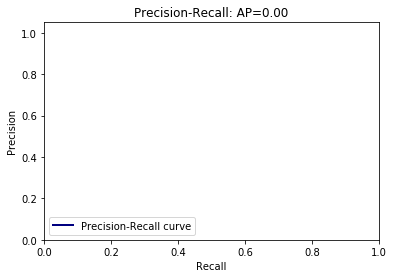

Mean AP for Rifle = 0.1152
Mean AP = 0.1097
~~~~~~~~
Results:
0.104
0.115
0.110


0.10973292210356476

In [51]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### Only lab - 2.5k unity

In [28]:
MODEL_NAME = 'weapons-onlylab-2.5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 68.0
FP: 42.0
FN: 192.0
Avg. overlap for Handgun = 0.7254
Predicted bounding boxes: small -> 64, medium -> 4, large -> 0, total -> 68
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6182
Recall for Handgun = 0.2615
AP for Handgun and IoU threshold 0.50 = 0.2303


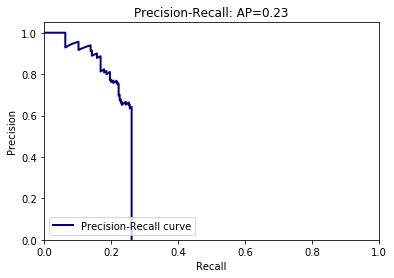

IoU threshold set to: 0.55
TP: 65.0
FP: 45.0
FN: 195.0
Avg. overlap for Handgun = 0.7341
Predicted bounding boxes: small -> 61, medium -> 4, large -> 0, total -> 65
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5909
Recall for Handgun = 0.2500
AP for Handgun and IoU threshold 0.55 = 0.2204


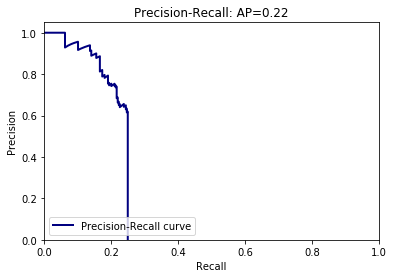

IoU threshold set to: 0.60
TP: 59.0
FP: 51.0
FN: 201.0
Avg. overlap for Handgun = 0.7498
Predicted bounding boxes: small -> 55, medium -> 4, large -> 0, total -> 59
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5364
Recall for Handgun = 0.2269
AP for Handgun and IoU threshold 0.60 = 0.1892


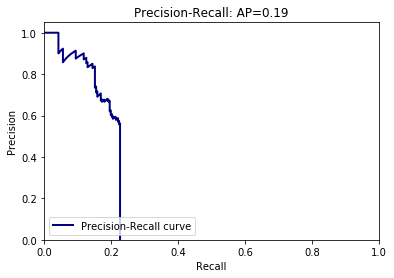

IoU threshold set to: 0.65
TP: 51.0
FP: 59.0
FN: 209.0
Avg. overlap for Handgun = 0.7687
Predicted bounding boxes: small -> 48, medium -> 3, large -> 0, total -> 51
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4636
Recall for Handgun = 0.1962
AP for Handgun and IoU threshold 0.65 = 0.1408


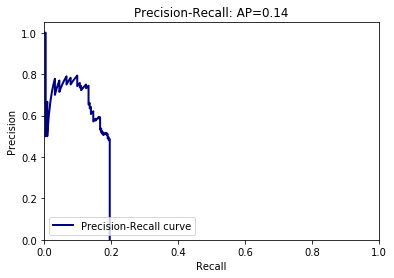

IoU threshold set to: 0.70
TP: 44.0
FP: 66.0
FN: 216.0
Avg. overlap for Handgun = 0.7831
Predicted bounding boxes: small -> 42, medium -> 2, large -> 0, total -> 44
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4000
Recall for Handgun = 0.1692
AP for Handgun and IoU threshold 0.70 = 0.1046


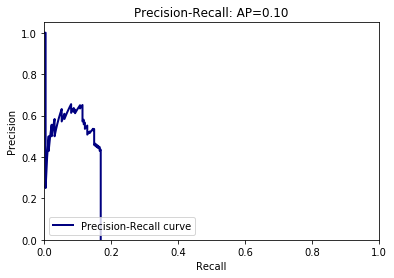

IoU threshold set to: 0.75
TP: 26.0
FP: 84.0
FN: 234.0
Avg. overlap for Handgun = 0.8208
Predicted bounding boxes: small -> 25, medium -> 1, large -> 0, total -> 26
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.2364
Recall for Handgun = 0.1000
AP for Handgun and IoU threshold 0.75 = 0.0347


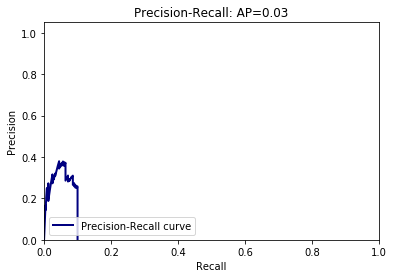

IoU threshold set to: 0.80
TP: 18.0
FP: 92.0
FN: 242.0
Avg. overlap for Handgun = 0.8400
Predicted bounding boxes: small -> 17, medium -> 1, large -> 0, total -> 18
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1636
Recall for Handgun = 0.0692
AP for Handgun and IoU threshold 0.80 = 0.0199


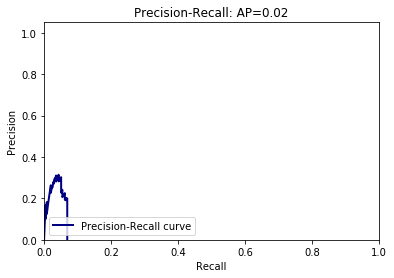

IoU threshold set to: 0.85
TP: 7.0
FP: 103.0
FN: 253.0
Avg. overlap for Handgun = 0.8774
Predicted bounding boxes: small -> 7, medium -> 0, large -> 0, total -> 7
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0636
Recall for Handgun = 0.0269
AP for Handgun and IoU threshold 0.85 = 0.0041


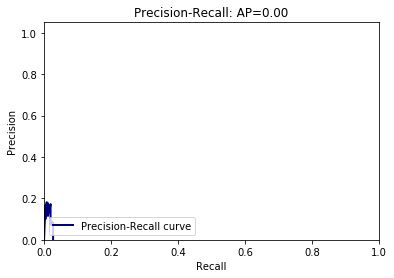

IoU threshold set to: 0.90
TP: 0.0
FP: 110.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.90 = 0.0000


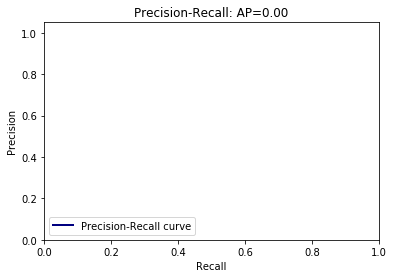

IoU threshold set to: 0.95
TP: 0.0
FP: 110.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


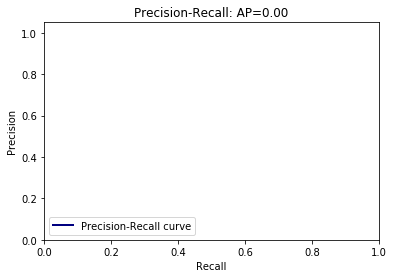

Mean AP for Handgun = 0.0944
IoU threshold set to: 0.50
TP: 66.0
FP: 11.0
FN: 154.0
Avg. overlap for Rifle = 0.7212
Predicted bounding boxes: small -> 36, medium -> 30, large -> 0, total -> 66
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8571
Recall for Rifle = 0.3000
AP for Rifle and IoU threshold 0.50 = 0.2788


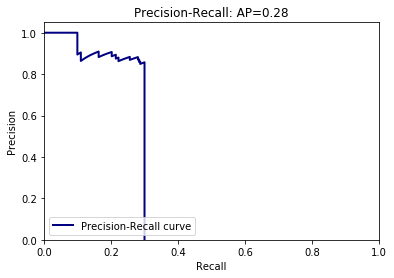

IoU threshold set to: 0.55
TP: 62.0
FP: 15.0
FN: 158.0
Avg. overlap for Rifle = 0.7329
Predicted bounding boxes: small -> 34, medium -> 28, large -> 0, total -> 62
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8052
Recall for Rifle = 0.2818
AP for Rifle and IoU threshold 0.55 = 0.2568


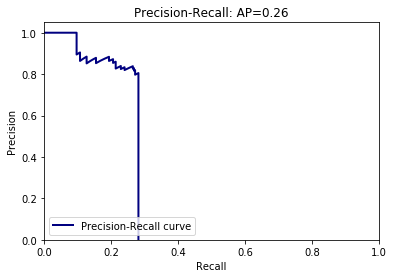

IoU threshold set to: 0.60
TP: 58.0
FP: 19.0
FN: 162.0
Avg. overlap for Rifle = 0.7430
Predicted bounding boxes: small -> 31, medium -> 27, large -> 0, total -> 58
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7532
Recall for Rifle = 0.2636
AP for Rifle and IoU threshold 0.60 = 0.2216


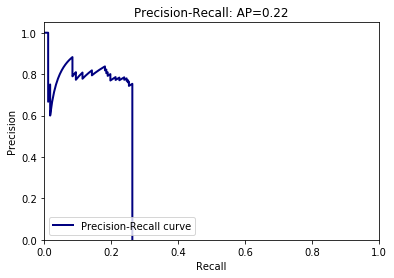

IoU threshold set to: 0.65
TP: 52.0
FP: 25.0
FN: 168.0
Avg. overlap for Rifle = 0.7568
Predicted bounding boxes: small -> 28, medium -> 24, large -> 0, total -> 52
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6753
Recall for Rifle = 0.2364
AP for Rifle and IoU threshold 0.65 = 0.1848


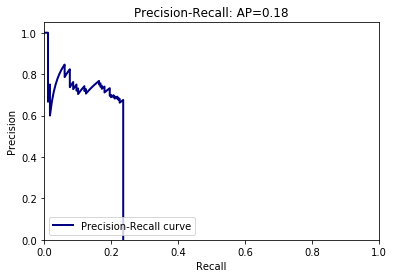

IoU threshold set to: 0.70
TP: 39.0
FP: 38.0
FN: 181.0
Avg. overlap for Rifle = 0.7818
Predicted bounding boxes: small -> 21, medium -> 18, large -> 0, total -> 39
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.5065
Recall for Rifle = 0.1773
AP for Rifle and IoU threshold 0.70 = 0.1095


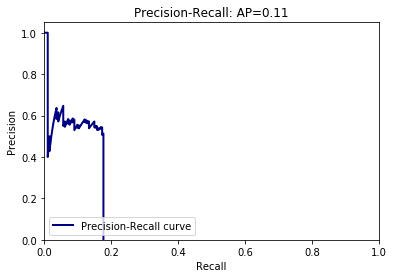

IoU threshold set to: 0.75
TP: 27.0
FP: 50.0
FN: 193.0
Avg. overlap for Rifle = 0.8087
Predicted bounding boxes: small -> 16, medium -> 11, large -> 0, total -> 27
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.3506
Recall for Rifle = 0.1227
AP for Rifle and IoU threshold 0.75 = 0.0589


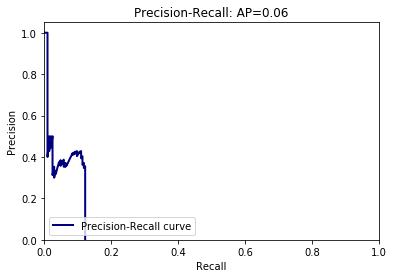

IoU threshold set to: 0.80
TP: 15.0
FP: 62.0
FN: 205.0
Avg. overlap for Rifle = 0.8337
Predicted bounding boxes: small -> 8, medium -> 7, large -> 0, total -> 15
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.1948
Recall for Rifle = 0.0682
AP for Rifle and IoU threshold 0.80 = 0.0231


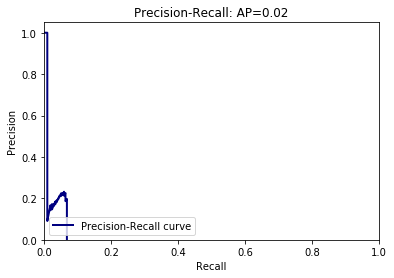

IoU threshold set to: 0.85
TP: 5.0
FP: 72.0
FN: 215.0
Avg. overlap for Rifle = 0.8688
Predicted bounding boxes: small -> 1, medium -> 4, large -> 0, total -> 5
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0649
Recall for Rifle = 0.0227
AP for Rifle and IoU threshold 0.85 = 0.0040


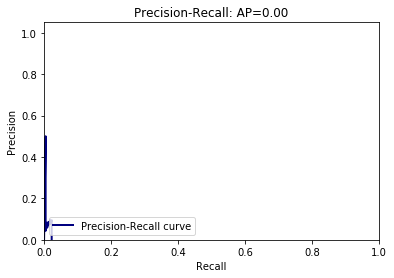

IoU threshold set to: 0.90
TP: 1.0
FP: 76.0
FN: 219.0
Avg. overlap for Rifle = 0.9062
Predicted bounding boxes: small -> 0, medium -> 1, large -> 0, total -> 1
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0130
Recall for Rifle = 0.0045
AP for Rifle and IoU threshold 0.90 = 0.0002


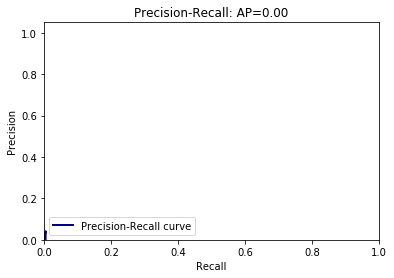

IoU threshold set to: 0.95
TP: 0.0
FP: 77.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


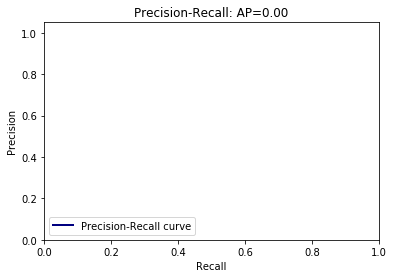

Mean AP for Rifle = 0.1138
Mean AP = 0.1041
~~~~~~~~
Results:
0.094
0.114
0.104


0.10408232159592223

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### Only lab - 5k unity

In [28]:
MODEL_NAME = 'weapons-onlylab-5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 57.0
FP: 24.0
FN: 203.0
Avg. overlap for Handgun = 0.7346
Predicted bounding boxes: small -> 56, medium -> 1, large -> 0, total -> 57
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.7037
Recall for Handgun = 0.2192
AP for Handgun and IoU threshold 0.50 = 0.1943


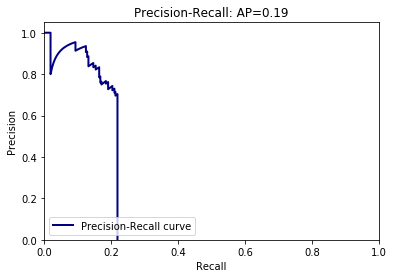

IoU threshold set to: 0.55
TP: 56.0
FP: 25.0
FN: 204.0
Avg. overlap for Handgun = 0.7380
Predicted bounding boxes: small -> 55, medium -> 1, large -> 0, total -> 56
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6914
Recall for Handgun = 0.2154
AP for Handgun and IoU threshold 0.55 = 0.1898


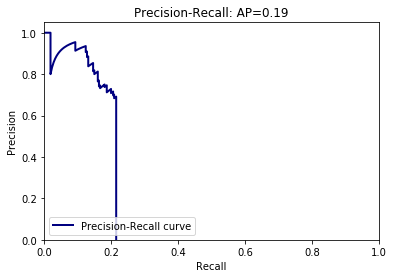

IoU threshold set to: 0.60
TP: 51.0
FP: 30.0
FN: 209.0
Avg. overlap for Handgun = 0.7545
Predicted bounding boxes: small -> 51, medium -> 0, large -> 0, total -> 51
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6296
Recall for Handgun = 0.1962
AP for Handgun and IoU threshold 0.60 = 0.1707


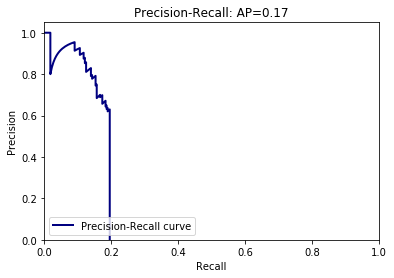

IoU threshold set to: 0.65
TP: 46.0
FP: 35.0
FN: 214.0
Avg. overlap for Handgun = 0.7672
Predicted bounding boxes: small -> 46, medium -> 0, large -> 0, total -> 46
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5679
Recall for Handgun = 0.1769
AP for Handgun and IoU threshold 0.65 = 0.1467


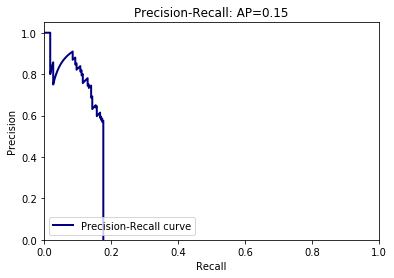

IoU threshold set to: 0.70
TP: 37.0
FP: 44.0
FN: 223.0
Avg. overlap for Handgun = 0.7904
Predicted bounding boxes: small -> 37, medium -> 0, large -> 0, total -> 37
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4568
Recall for Handgun = 0.1423
AP for Handgun and IoU threshold 0.70 = 0.1000


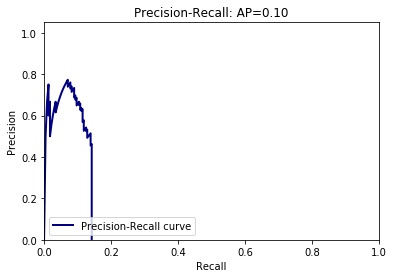

IoU threshold set to: 0.75
TP: 25.0
FP: 56.0
FN: 235.0
Avg. overlap for Handgun = 0.8231
Predicted bounding boxes: small -> 25, medium -> 0, large -> 0, total -> 25
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.3086
Recall for Handgun = 0.0962
AP for Handgun and IoU threshold 0.75 = 0.0541


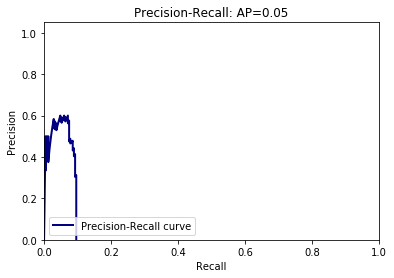

IoU threshold set to: 0.80
TP: 16.0
FP: 65.0
FN: 244.0
Avg. overlap for Handgun = 0.8522
Predicted bounding boxes: small -> 16, medium -> 0, large -> 0, total -> 16
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1975
Recall for Handgun = 0.0615
AP for Handgun and IoU threshold 0.80 = 0.0264


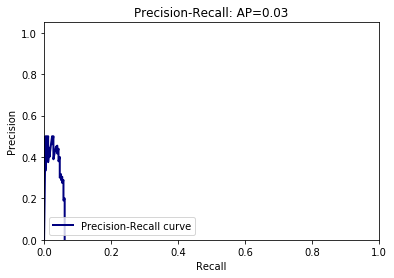

IoU threshold set to: 0.85
TP: 7.0
FP: 74.0
FN: 253.0
Avg. overlap for Handgun = 0.8879
Predicted bounding boxes: small -> 7, medium -> 0, large -> 0, total -> 7
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0864
Recall for Handgun = 0.0269
AP for Handgun and IoU threshold 0.85 = 0.0058


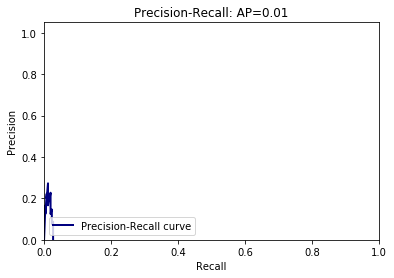

IoU threshold set to: 0.90
TP: 3.0
FP: 78.0
FN: 257.0
Avg. overlap for Handgun = 0.9139
Predicted bounding boxes: small -> 3, medium -> 0, large -> 0, total -> 3
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0370
Recall for Handgun = 0.0115
AP for Handgun and IoU threshold 0.90 = 0.0020


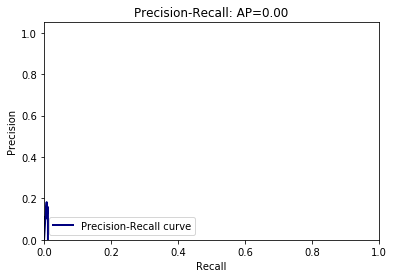

IoU threshold set to: 0.95
TP: 0.0
FP: 81.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


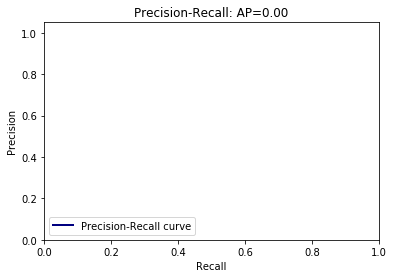

Mean AP for Handgun = 0.0890
IoU threshold set to: 0.50
TP: 51.0
FP: 11.0
FN: 169.0
Avg. overlap for Rifle = 0.7362
Predicted bounding boxes: small -> 29, medium -> 22, large -> 0, total -> 51
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8226
Recall for Rifle = 0.2318
AP for Rifle and IoU threshold 0.50 = 0.2187


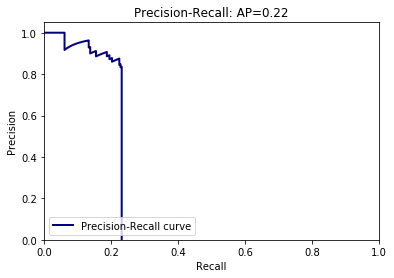

IoU threshold set to: 0.55
TP: 50.0
FP: 12.0
FN: 170.0
Avg. overlap for Rifle = 0.7401
Predicted bounding boxes: small -> 29, medium -> 21, large -> 0, total -> 50
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8065
Recall for Rifle = 0.2273
AP for Rifle and IoU threshold 0.55 = 0.2101


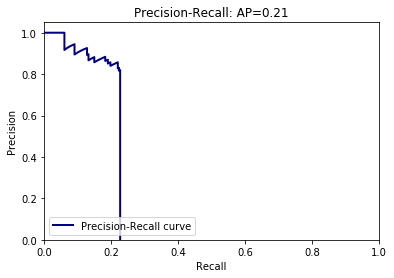

IoU threshold set to: 0.60
TP: 47.0
FP: 15.0
FN: 173.0
Avg. overlap for Rifle = 0.7510
Predicted bounding boxes: small -> 27, medium -> 20, large -> 0, total -> 47
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7581
Recall for Rifle = 0.2136
AP for Rifle and IoU threshold 0.60 = 0.1964


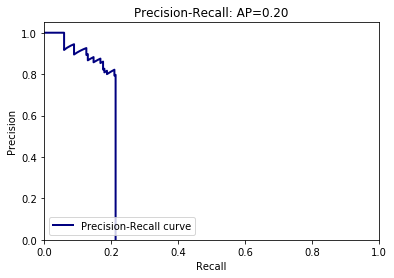

IoU threshold set to: 0.65
TP: 42.0
FP: 20.0
FN: 178.0
Avg. overlap for Rifle = 0.7668
Predicted bounding boxes: small -> 23, medium -> 19, large -> 0, total -> 42
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6774
Recall for Rifle = 0.1909
AP for Rifle and IoU threshold 0.65 = 0.1574


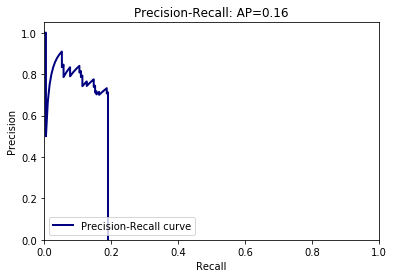

IoU threshold set to: 0.70
TP: 32.0
FP: 30.0
FN: 188.0
Avg. overlap for Rifle = 0.7953
Predicted bounding boxes: small -> 16, medium -> 16, large -> 0, total -> 32
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.5161
Recall for Rifle = 0.1455
AP for Rifle and IoU threshold 0.70 = 0.1074


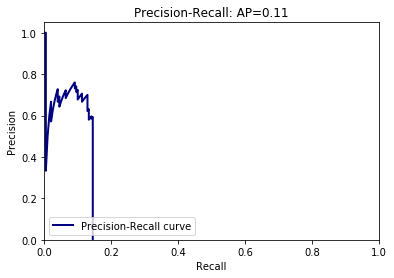

IoU threshold set to: 0.75
TP: 24.0
FP: 38.0
FN: 196.0
Avg. overlap for Rifle = 0.8190
Predicted bounding boxes: small -> 12, medium -> 12, large -> 0, total -> 24
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.3871
Recall for Rifle = 0.1091
AP for Rifle and IoU threshold 0.75 = 0.0727


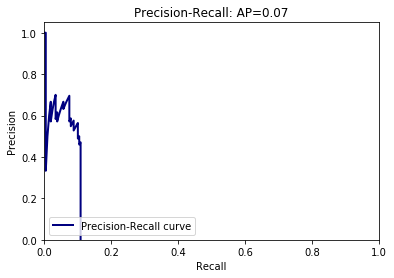

IoU threshold set to: 0.80
TP: 17.0
FP: 45.0
FN: 203.0
Avg. overlap for Rifle = 0.8384
Predicted bounding boxes: small -> 7, medium -> 10, large -> 0, total -> 17
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.2742
Recall for Rifle = 0.0773
AP for Rifle and IoU threshold 0.80 = 0.0348


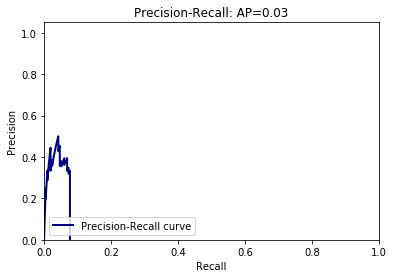

IoU threshold set to: 0.85
TP: 4.0
FP: 58.0
FN: 216.0
Avg. overlap for Rifle = 0.8915
Predicted bounding boxes: small -> 1, medium -> 3, large -> 0, total -> 4
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0645
Recall for Rifle = 0.0182
AP for Rifle and IoU threshold 0.85 = 0.0027


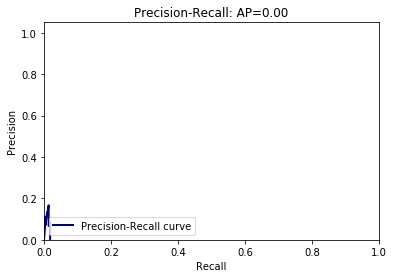

IoU threshold set to: 0.90
TP: 2.0
FP: 60.0
FN: 218.0
Avg. overlap for Rifle = 0.9174
Predicted bounding boxes: small -> 1, medium -> 1, large -> 0, total -> 2
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0323
Recall for Rifle = 0.0091
AP for Rifle and IoU threshold 0.90 = 0.0007


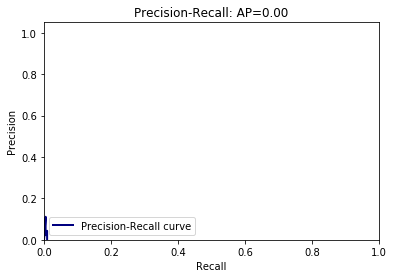

IoU threshold set to: 0.95
TP: 0.0
FP: 62.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


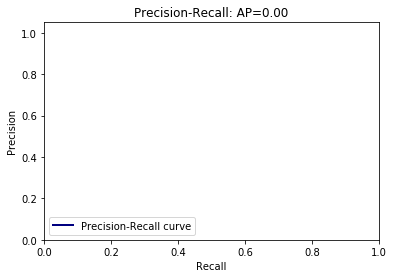

Mean AP for Rifle = 0.1001
Mean AP = 0.0945
~~~~~~~~
Results:
0.089
0.100
0.095


0.09452961725339021

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### All - 0k unity

In [28]:
MODEL_NAME = 'weapons-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 69.0
FP: 41.0
FN: 191.0
Avg. overlap for Handgun = 0.7463
Predicted bounding boxes: small -> 66, medium -> 3, large -> 0, total -> 69
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6273
Recall for Handgun = 0.2654
AP for Handgun and IoU threshold 0.50 = 0.2318


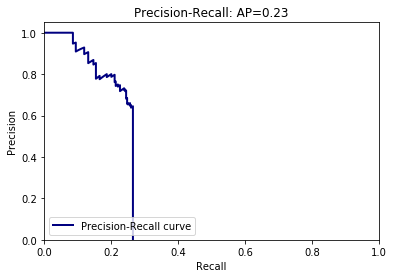

IoU threshold set to: 0.55
TP: 66.0
FP: 44.0
FN: 194.0
Avg. overlap for Handgun = 0.7560
Predicted bounding boxes: small -> 63, medium -> 3, large -> 0, total -> 66
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.6000
Recall for Handgun = 0.2538
AP for Handgun and IoU threshold 0.55 = 0.2214


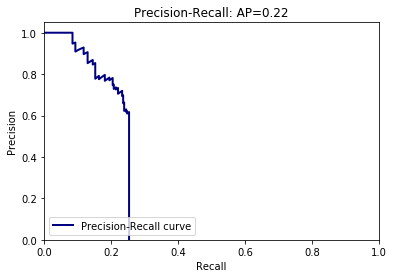

IoU threshold set to: 0.60
TP: 62.0
FP: 48.0
FN: 198.0
Avg. overlap for Handgun = 0.7673
Predicted bounding boxes: small -> 60, medium -> 2, large -> 0, total -> 62
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5636
Recall for Handgun = 0.2385
AP for Handgun and IoU threshold 0.60 = 0.2007


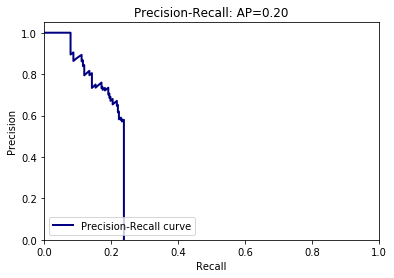

IoU threshold set to: 0.65
TP: 56.0
FP: 54.0
FN: 204.0
Avg. overlap for Handgun = 0.7829
Predicted bounding boxes: small -> 54, medium -> 2, large -> 0, total -> 56
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5091
Recall for Handgun = 0.2154
AP for Handgun and IoU threshold 0.65 = 0.1730


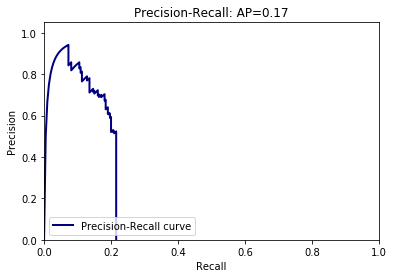

IoU threshold set to: 0.70
TP: 48.0
FP: 62.0
FN: 212.0
Avg. overlap for Handgun = 0.8013
Predicted bounding boxes: small -> 46, medium -> 2, large -> 0, total -> 48
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4364
Recall for Handgun = 0.1846
AP for Handgun and IoU threshold 0.70 = 0.1425


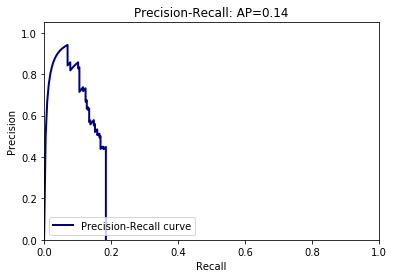

IoU threshold set to: 0.75
TP: 40.0
FP: 70.0
FN: 220.0
Avg. overlap for Handgun = 0.8155
Predicted bounding boxes: small -> 38, medium -> 2, large -> 0, total -> 40
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.3636
Recall for Handgun = 0.1538
AP for Handgun and IoU threshold 0.75 = 0.1031


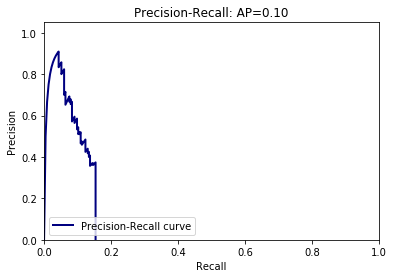

IoU threshold set to: 0.80
TP: 20.0
FP: 90.0
FN: 240.0
Avg. overlap for Handgun = 0.8604
Predicted bounding boxes: small -> 19, medium -> 1, large -> 0, total -> 20
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1818
Recall for Handgun = 0.0769
AP for Handgun and IoU threshold 0.80 = 0.0275


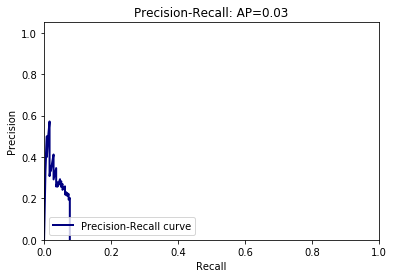

IoU threshold set to: 0.85
TP: 10.0
FP: 100.0
FN: 250.0
Avg. overlap for Handgun = 0.8880
Predicted bounding boxes: small -> 9, medium -> 1, large -> 0, total -> 10
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0909
Recall for Handgun = 0.0385
AP for Handgun and IoU threshold 0.85 = 0.0095


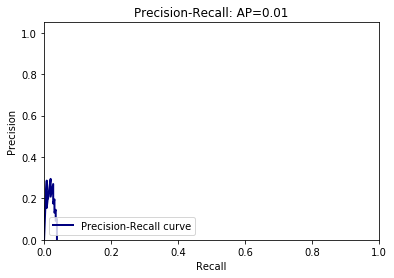

IoU threshold set to: 0.90
TP: 5.0
FP: 105.0
FN: 255.0
Avg. overlap for Handgun = 0.9112
Predicted bounding boxes: small -> 4, medium -> 1, large -> 0, total -> 5
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0455
Recall for Handgun = 0.0192
AP for Handgun and IoU threshold 0.90 = 0.0040


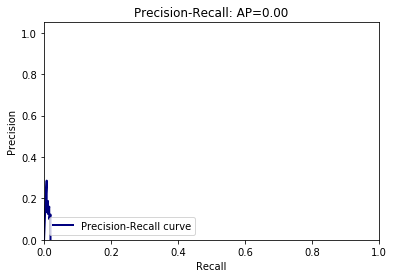

IoU threshold set to: 0.95
TP: 0.0
FP: 110.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


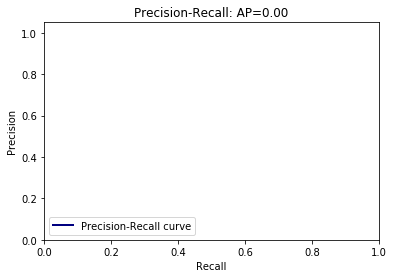

Mean AP for Handgun = 0.1113
IoU threshold set to: 0.50
TP: 55.0
FP: 11.0
FN: 165.0
Avg. overlap for Rifle = 0.7211
Predicted bounding boxes: small -> 30, medium -> 25, large -> 0, total -> 55
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8333
Recall for Rifle = 0.2500
AP for Rifle and IoU threshold 0.50 = 0.2386


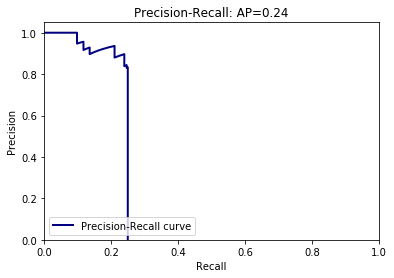

IoU threshold set to: 0.55
TP: 50.0
FP: 16.0
FN: 170.0
Avg. overlap for Rifle = 0.7399
Predicted bounding boxes: small -> 27, medium -> 23, large -> 0, total -> 50
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7576
Recall for Rifle = 0.2273
AP for Rifle and IoU threshold 0.55 = 0.2117


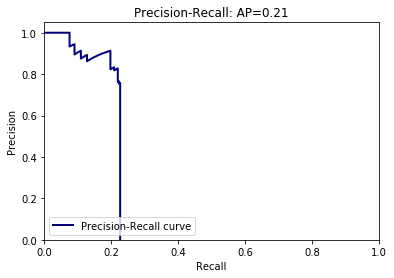

IoU threshold set to: 0.60
TP: 47.0
FP: 19.0
FN: 173.0
Avg. overlap for Rifle = 0.7506
Predicted bounding boxes: small -> 26, medium -> 21, large -> 0, total -> 47
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7121
Recall for Rifle = 0.2136
AP for Rifle and IoU threshold 0.60 = 0.1856


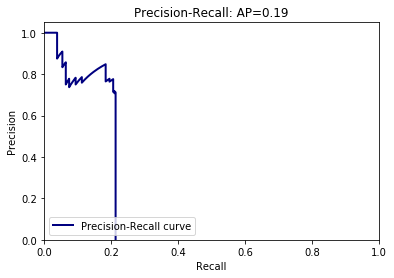

IoU threshold set to: 0.65
TP: 44.0
FP: 22.0
FN: 176.0
Avg. overlap for Rifle = 0.7592
Predicted bounding boxes: small -> 26, medium -> 18, large -> 0, total -> 44
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6667
Recall for Rifle = 0.2000
AP for Rifle and IoU threshold 0.65 = 0.1670


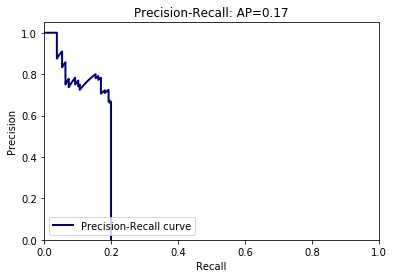

IoU threshold set to: 0.70
TP: 35.0
FP: 31.0
FN: 185.0
Avg. overlap for Rifle = 0.7811
Predicted bounding boxes: small -> 19, medium -> 16, large -> 0, total -> 35
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.5303
Recall for Rifle = 0.1591
AP for Rifle and IoU threshold 0.70 = 0.1176


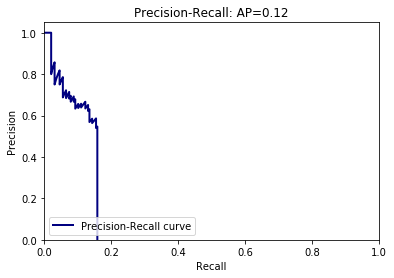

IoU threshold set to: 0.75
TP: 20.0
FP: 46.0
FN: 200.0
Avg. overlap for Rifle = 0.8221
Predicted bounding boxes: small -> 11, medium -> 9, large -> 0, total -> 20
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.3030
Recall for Rifle = 0.0909
AP for Rifle and IoU threshold 0.75 = 0.0445


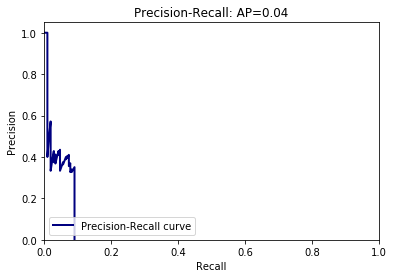

IoU threshold set to: 0.80
TP: 12.0
FP: 54.0
FN: 208.0
Avg. overlap for Rifle = 0.8519
Predicted bounding boxes: small -> 6, medium -> 6, large -> 0, total -> 12
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.1818
Recall for Rifle = 0.0545
AP for Rifle and IoU threshold 0.80 = 0.0222


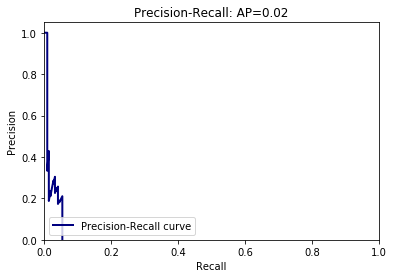

IoU threshold set to: 0.85
TP: 6.0
FP: 60.0
FN: 214.0
Avg. overlap for Rifle = 0.8796
Predicted bounding boxes: small -> 3, medium -> 3, large -> 0, total -> 6
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0909
Recall for Rifle = 0.0273
AP for Rifle and IoU threshold 0.85 = 0.0086


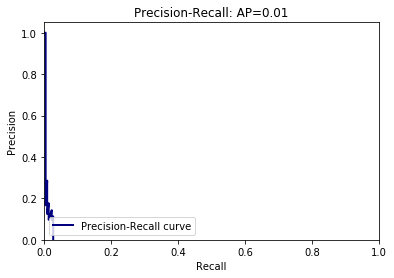

IoU threshold set to: 0.90
TP: 1.0
FP: 65.0
FN: 219.0
Avg. overlap for Rifle = 0.9103
Predicted bounding boxes: small -> 1, medium -> 0, large -> 0, total -> 1
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0152
Recall for Rifle = 0.0045
AP for Rifle and IoU threshold 0.90 = 0.0006


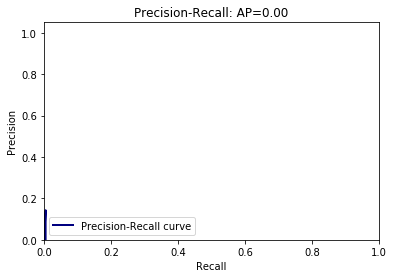

IoU threshold set to: 0.95
TP: 0.0
FP: 66.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


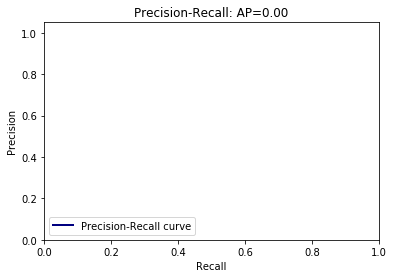

Mean AP for Rifle = 0.0996
Mean AP = 0.1055
~~~~~~~~
Results:
0.111
0.100
0.105


0.1054867632953986

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### All - 1k unity

In [28]:
MODEL_NAME = 'weapons-1kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

IoU threshold set to: 0.50
TP: 71.0
FP: 55.0
FN: 189.0
Avg. overlap for Handgun = 0.7292
Predicted bounding boxes: small -> 70, medium -> 1, large -> 0, total -> 71
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5635
Recall for Handgun = 0.2731
AP for Handgun and IoU threshold 0.50 = 0.2341


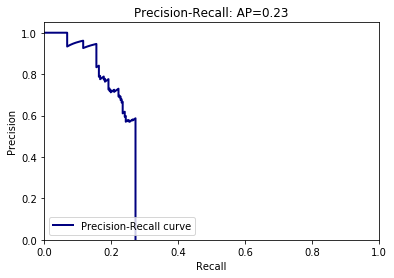

IoU threshold set to: 0.55
TP: 69.0
FP: 57.0
FN: 191.0
Avg. overlap for Handgun = 0.7348
Predicted bounding boxes: small -> 68, medium -> 1, large -> 0, total -> 69
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5476
Recall for Handgun = 0.2654
AP for Handgun and IoU threshold 0.55 = 0.2285


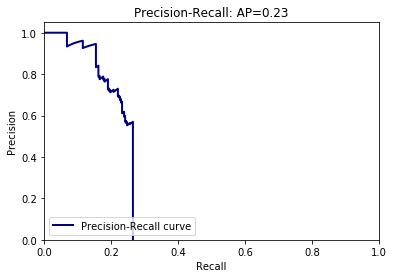

IoU threshold set to: 0.60
TP: 65.0
FP: 61.0
FN: 195.0
Avg. overlap for Handgun = 0.7441
Predicted bounding boxes: small -> 64, medium -> 1, large -> 0, total -> 65
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.5159
Recall for Handgun = 0.2500
AP for Handgun and IoU threshold 0.60 = 0.2108


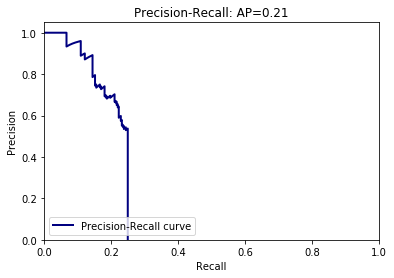

IoU threshold set to: 0.65
TP: 52.0
FP: 74.0
FN: 208.0
Avg. overlap for Handgun = 0.7739
Predicted bounding boxes: small -> 51, medium -> 1, large -> 0, total -> 52
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.4127
Recall for Handgun = 0.2000
AP for Handgun and IoU threshold 0.65 = 0.1632


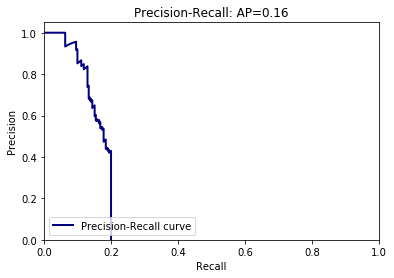

IoU threshold set to: 0.70
TP: 45.0
FP: 81.0
FN: 215.0
Avg. overlap for Handgun = 0.7890
Predicted bounding boxes: small -> 45, medium -> 0, large -> 0, total -> 45
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.3571
Recall for Handgun = 0.1731
AP for Handgun and IoU threshold 0.70 = 0.1420


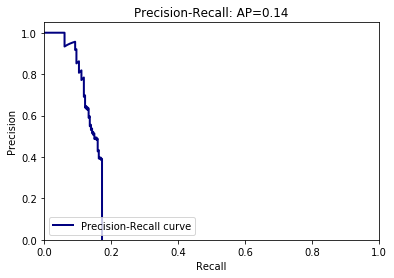

IoU threshold set to: 0.75
TP: 31.0
FP: 95.0
FN: 229.0
Avg. overlap for Handgun = 0.8164
Predicted bounding boxes: small -> 31, medium -> 0, large -> 0, total -> 31
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.2460
Recall for Handgun = 0.1192
AP for Handgun and IoU threshold 0.75 = 0.0847


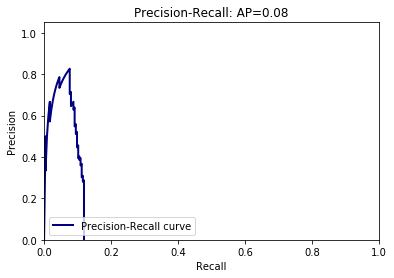

IoU threshold set to: 0.80
TP: 16.0
FP: 110.0
FN: 244.0
Avg. overlap for Handgun = 0.8534
Predicted bounding boxes: small -> 16, medium -> 0, large -> 0, total -> 16
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.1270
Recall for Handgun = 0.0615
AP for Handgun and IoU threshold 0.80 = 0.0242


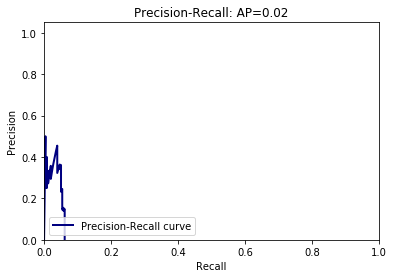

IoU threshold set to: 0.85
TP: 7.0
FP: 119.0
FN: 253.0
Avg. overlap for Handgun = 0.8951
Predicted bounding boxes: small -> 7, medium -> 0, large -> 0, total -> 7
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0556
Recall for Handgun = 0.0269
AP for Handgun and IoU threshold 0.85 = 0.0060


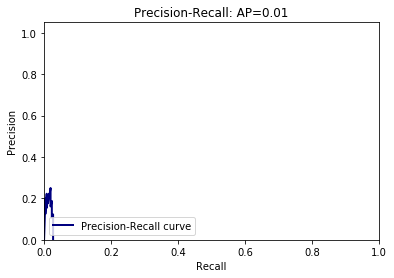

IoU threshold set to: 0.90
TP: 2.0
FP: 124.0
FN: 258.0
Avg. overlap for Handgun = 0.9219
Predicted bounding boxes: small -> 2, medium -> 0, large -> 0, total -> 2
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0159
Recall for Handgun = 0.0077
AP for Handgun and IoU threshold 0.90 = 0.0017


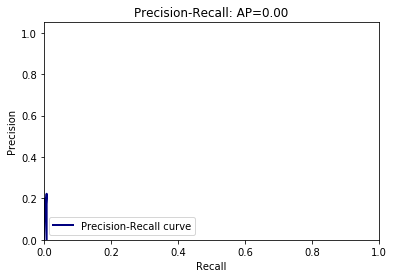

IoU threshold set to: 0.95
TP: 0.0
FP: 126.0
FN: 260.0
Avg. overlap for Handgun = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 248, medium -> 12, large -> 0, total -> 260
Precision for Handgun = 0.0000
Recall for Handgun = 0.0000
AP for Handgun and IoU threshold 0.95 = 0.0000


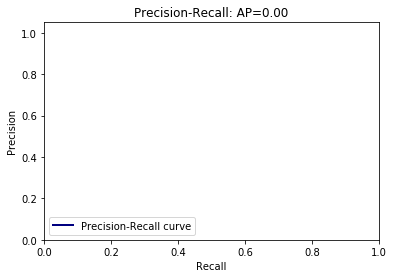

Mean AP for Handgun = 0.1095
IoU threshold set to: 0.50
TP: 55.0
FP: 8.0
FN: 165.0
Avg. overlap for Rifle = 0.7314
Predicted bounding boxes: small -> 30, medium -> 25, large -> 0, total -> 55
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8730
Recall for Rifle = 0.2500
AP for Rifle and IoU threshold 0.50 = 0.2313


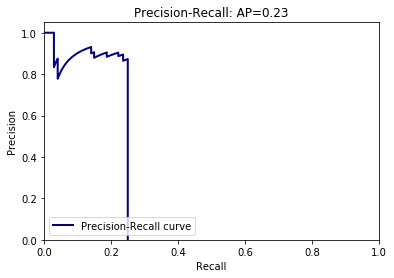

IoU threshold set to: 0.55
TP: 53.0
FP: 10.0
FN: 167.0
Avg. overlap for Rifle = 0.7395
Predicted bounding boxes: small -> 30, medium -> 23, large -> 0, total -> 53
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.8413
Recall for Rifle = 0.2409
AP for Rifle and IoU threshold 0.55 = 0.2137


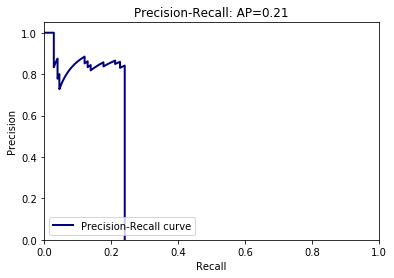

IoU threshold set to: 0.60
TP: 50.0
FP: 13.0
FN: 170.0
Avg. overlap for Rifle = 0.7495
Predicted bounding boxes: small -> 29, medium -> 21, large -> 0, total -> 50
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.7937
Recall for Rifle = 0.2273
AP for Rifle and IoU threshold 0.60 = 0.1948


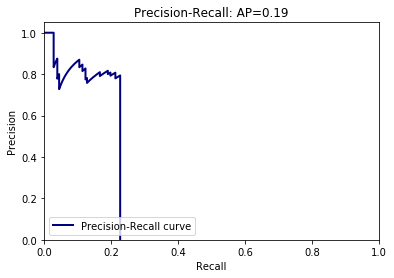

IoU threshold set to: 0.65
TP: 43.0
FP: 20.0
FN: 177.0
Avg. overlap for Rifle = 0.7687
Predicted bounding boxes: small -> 25, medium -> 18, large -> 0, total -> 43
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.6825
Recall for Rifle = 0.1955
AP for Rifle and IoU threshold 0.65 = 0.1491


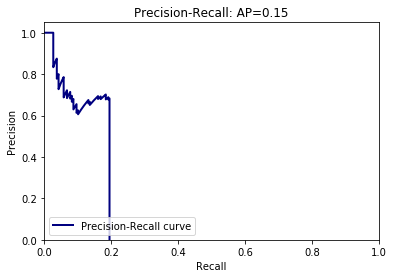

IoU threshold set to: 0.70
TP: 32.0
FP: 31.0
FN: 188.0
Avg. overlap for Rifle = 0.7983
Predicted bounding boxes: small -> 17, medium -> 15, large -> 0, total -> 32
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.5079
Recall for Rifle = 0.1455
AP for Rifle and IoU threshold 0.70 = 0.0876


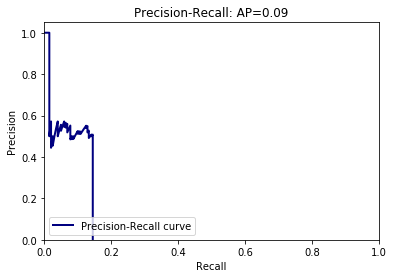

IoU threshold set to: 0.75
TP: 26.0
FP: 37.0
FN: 194.0
Avg. overlap for Rifle = 0.8126
Predicted bounding boxes: small -> 13, medium -> 13, large -> 0, total -> 26
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.4127
Recall for Rifle = 0.1182
AP for Rifle and IoU threshold 0.75 = 0.0657


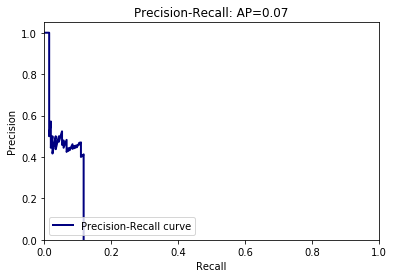

IoU threshold set to: 0.80
TP: 13.0
FP: 50.0
FN: 207.0
Avg. overlap for Rifle = 0.8495
Predicted bounding boxes: small -> 8, medium -> 5, large -> 0, total -> 13
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.2063
Recall for Rifle = 0.0591
AP for Rifle and IoU threshold 0.80 = 0.0135


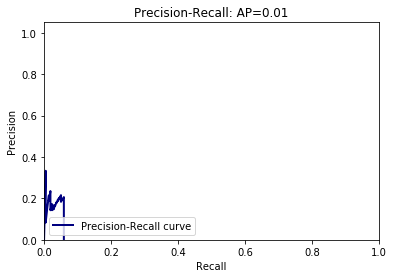

IoU threshold set to: 0.85
TP: 4.0
FP: 59.0
FN: 216.0
Avg. overlap for Rifle = 0.8925
Predicted bounding boxes: small -> 2, medium -> 2, large -> 0, total -> 4
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0635
Recall for Rifle = 0.0182
AP for Rifle and IoU threshold 0.85 = 0.0017


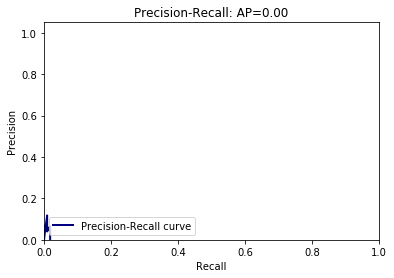

IoU threshold set to: 0.90
TP: 2.0
FP: 61.0
FN: 218.0
Avg. overlap for Rifle = 0.9198
Predicted bounding boxes: small -> 1, medium -> 1, large -> 0, total -> 2
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0317
Recall for Rifle = 0.0091
AP for Rifle and IoU threshold 0.90 = 0.0005


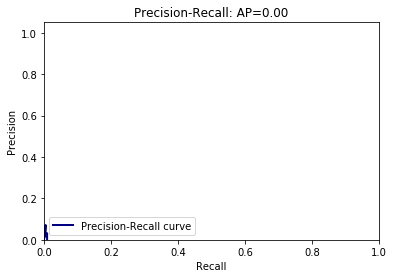

IoU threshold set to: 0.95
TP: 0.0
FP: 63.0
FN: 220.0
Avg. overlap for Rifle = 0.0000
Predicted bounding boxes: small -> 0, medium -> 0, large -> 0, total -> 0
GT bounding boxes: small -> 145, medium -> 75, large -> 0, total -> 220
Precision for Rifle = 0.0000
Recall for Rifle = 0.0000
AP for Rifle and IoU threshold 0.95 = 0.0000


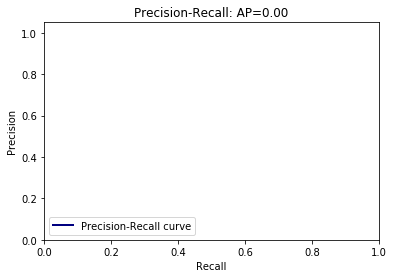

Mean AP for Rifle = 0.0958
Mean AP = 0.1027
~~~~~~~~
Results:
0.110
0.096
0.103


0.10265300853766916

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### All - 2.5k unity

In [30]:
MODEL_NAME = 'weapons-2.5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m2_5kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.2436


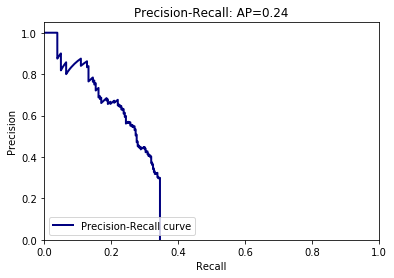

AP for Handgun and IoU threshold 0.55 = 0.2112


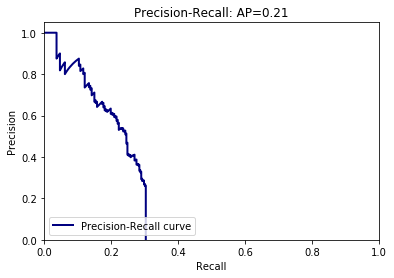

AP for Handgun and IoU threshold 0.60 = 0.1879


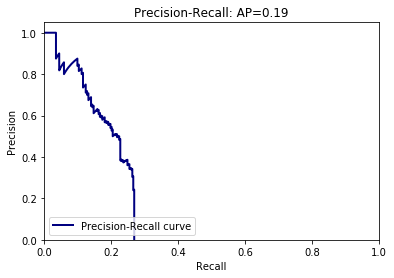

AP for Handgun and IoU threshold 0.65 = 0.1566


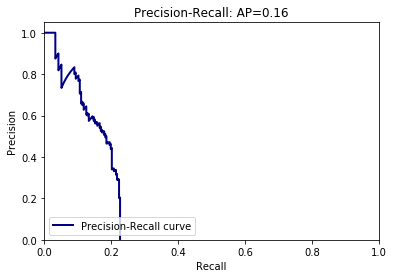

AP for Handgun and IoU threshold 0.70 = 0.0927


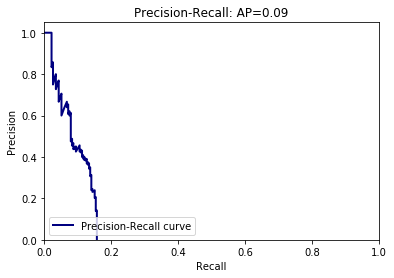

AP for Handgun and IoU threshold 0.75 = 0.0551


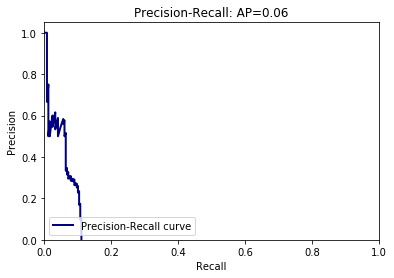

AP for Handgun and IoU threshold 0.80 = 0.0166


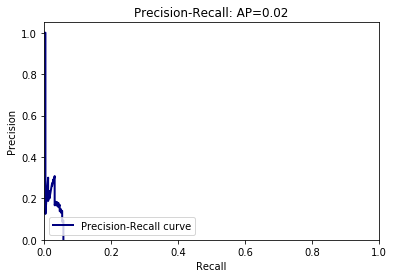

AP for Handgun and IoU threshold 0.85 = 0.0075


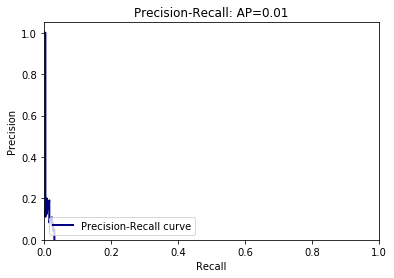

AP for Handgun and IoU threshold 0.90 = 0.0006


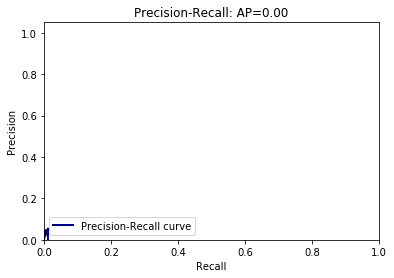

AP for Handgun and IoU threshold 0.95 = 0.0001


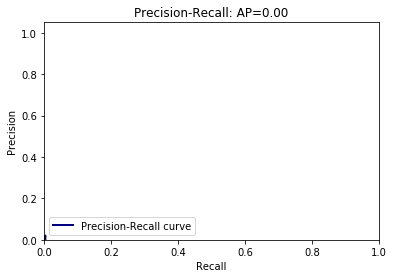

Mean AP for Handgun = 0.0972
AP for Rifle and IoU threshold 0.50 = 0.3609


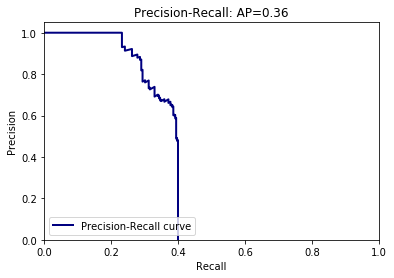

AP for Rifle and IoU threshold 0.55 = 0.3224


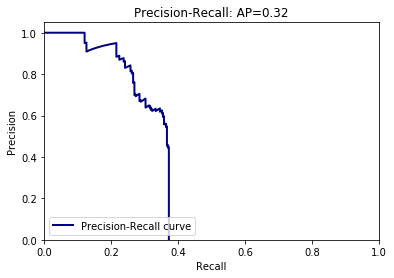

AP for Rifle and IoU threshold 0.60 = 0.2980


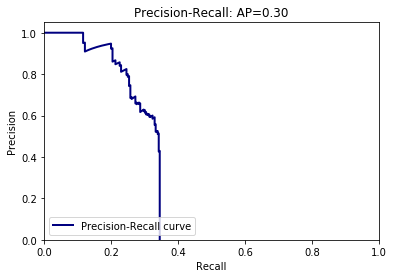

AP for Rifle and IoU threshold 0.65 = 0.2166


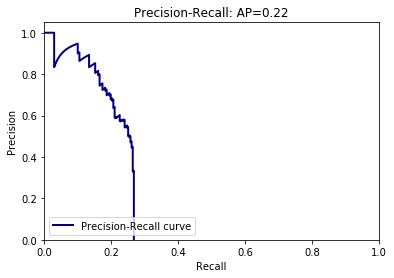

AP for Rifle and IoU threshold 0.70 = 0.1433


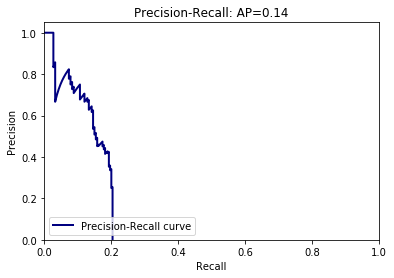

AP for Rifle and IoU threshold 0.75 = 0.0730


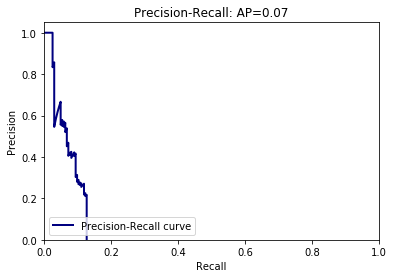

AP for Rifle and IoU threshold 0.80 = 0.0198


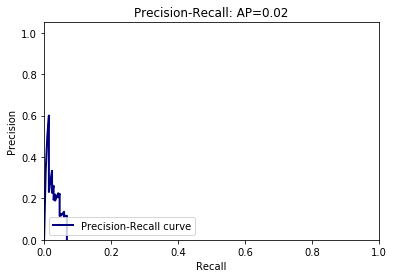

AP for Rifle and IoU threshold 0.85 = 0.0005


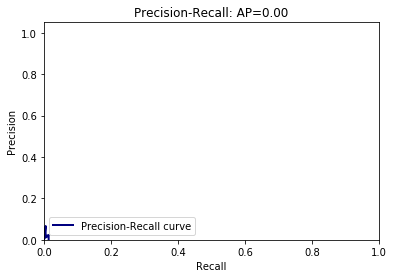

AP for Rifle and IoU threshold 0.90 = 0.0000


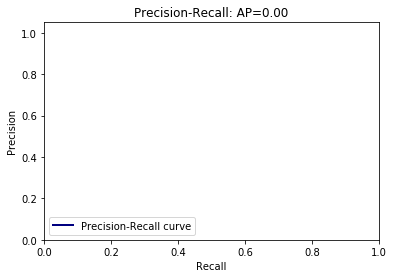

AP for Rifle and IoU threshold 0.95 = 0.0000


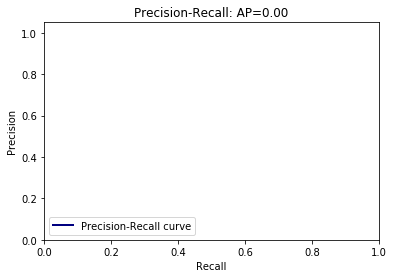

Mean AP for Rifle = 0.1435
Mean AP = 0.1203
~~~~~~~~
Results:
0.097
0.143
0.120


0.12032451406611011

In [31]:
compute_mean_average_precision_COCO2016(m2_5kunity_detections)

### All - 5k unity

In [32]:
MODEL_NAME = 'weapons-5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m5kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.2312


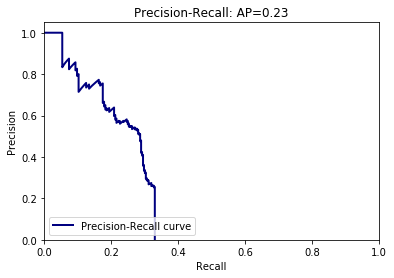

AP for Handgun and IoU threshold 0.55 = 0.2101


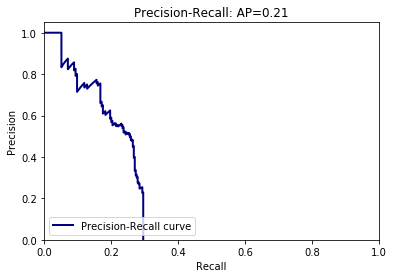

AP for Handgun and IoU threshold 0.60 = 0.1847


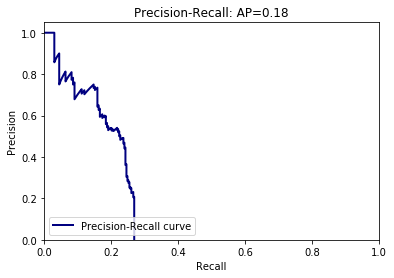

AP for Handgun and IoU threshold 0.65 = 0.1439


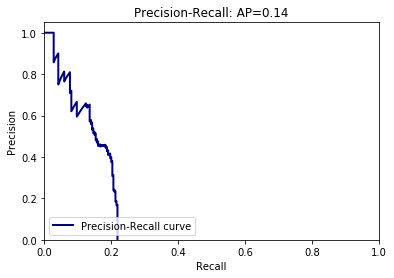

AP for Handgun and IoU threshold 0.70 = 0.1158


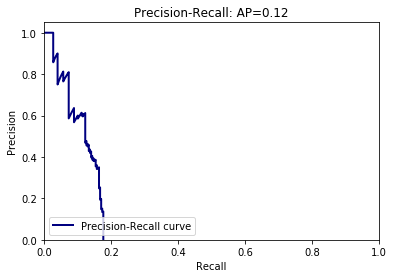

AP for Handgun and IoU threshold 0.75 = 0.0659


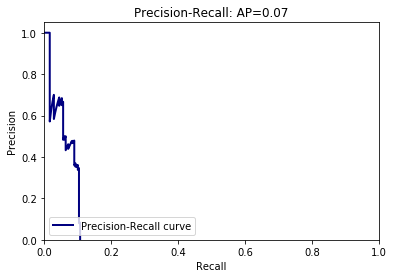

AP for Handgun and IoU threshold 0.80 = 0.0164


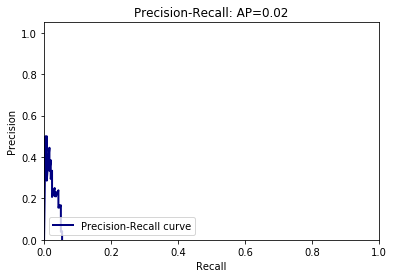

AP for Handgun and IoU threshold 0.85 = 0.0030


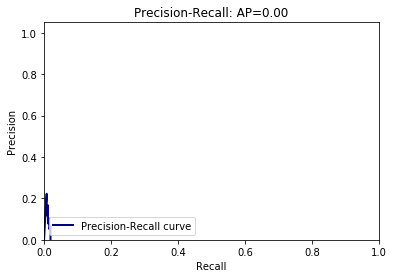

AP for Handgun and IoU threshold 0.90 = 0.0005


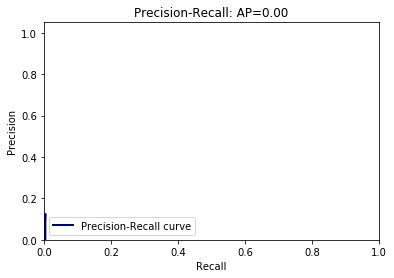

AP for Handgun and IoU threshold 0.95 = 0.0000


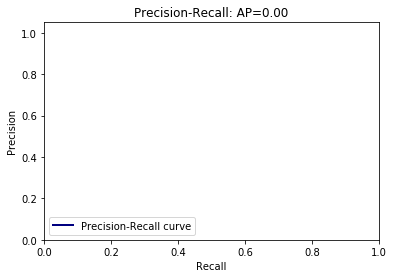

Mean AP for Handgun = 0.0971
AP for Rifle and IoU threshold 0.50 = 0.3071


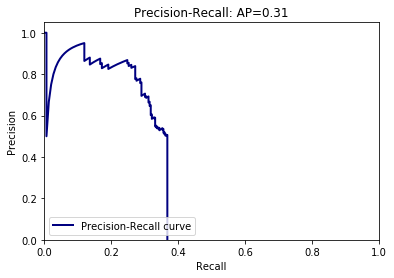

AP for Rifle and IoU threshold 0.55 = 0.2920


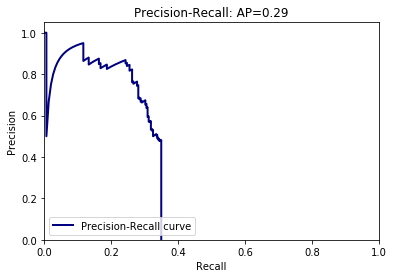

AP for Rifle and IoU threshold 0.60 = 0.2244


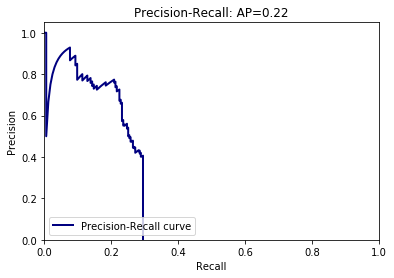

AP for Rifle and IoU threshold 0.65 = 0.1773


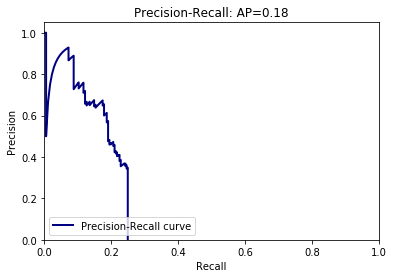

AP for Rifle and IoU threshold 0.70 = 0.1055


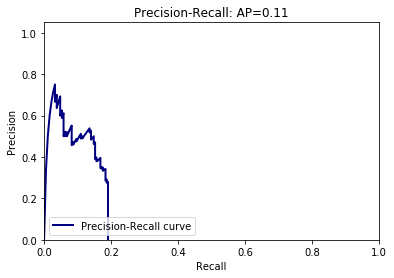

AP for Rifle and IoU threshold 0.75 = 0.0410


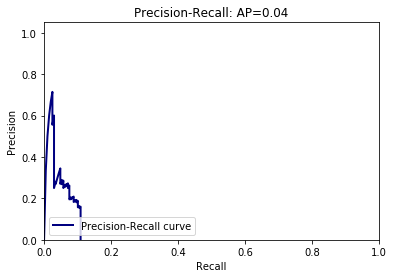

AP for Rifle and IoU threshold 0.80 = 0.0110


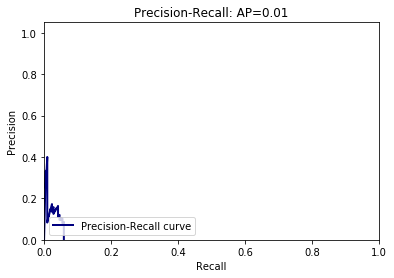

AP for Rifle and IoU threshold 0.85 = 0.0021


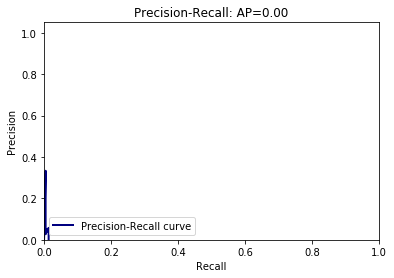

AP for Rifle and IoU threshold 0.90 = 0.0000


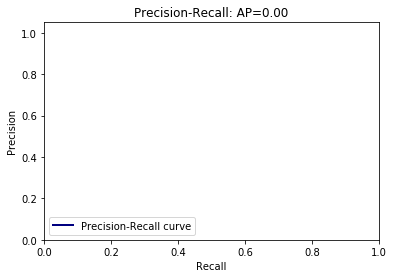

AP for Rifle and IoU threshold 0.95 = 0.0000


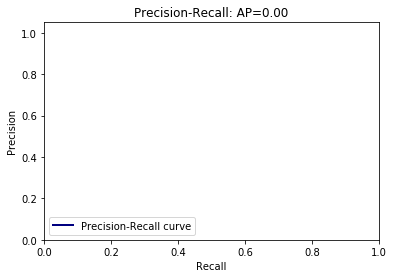

Mean AP for Rifle = 0.1160
Mean AP = 0.1066
~~~~~~~~
Results:
0.097
0.116
0.107


0.10659314243771881

In [33]:
compute_mean_average_precision_COCO2016(m5kunity_detections)

## mAPs Cam 5

In [3]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam5'

### Only lab - 0k unity

In [30]:
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.1332


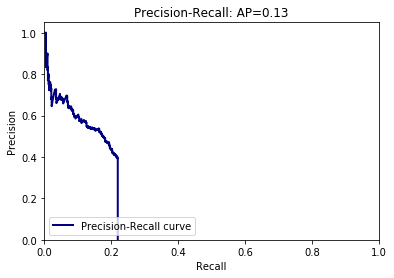

AP for Handgun and IoU threshold 0.55 = 0.1054


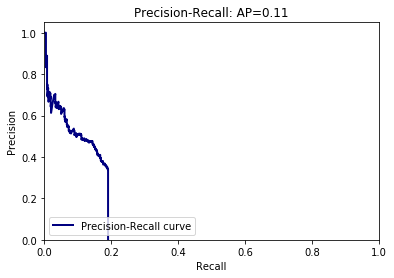

AP for Handgun and IoU threshold 0.60 = 0.0740


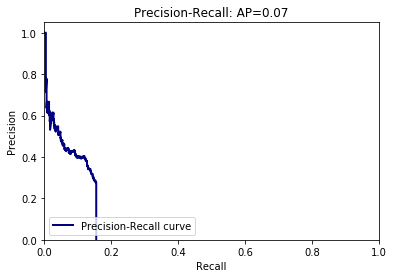

AP for Handgun and IoU threshold 0.65 = 0.0418


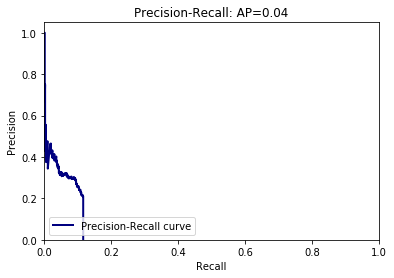

AP for Handgun and IoU threshold 0.70 = 0.0220


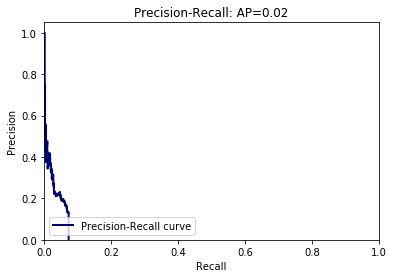

AP for Handgun and IoU threshold 0.75 = 0.0117


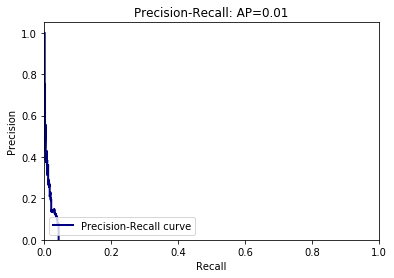

AP for Handgun and IoU threshold 0.80 = 0.0036


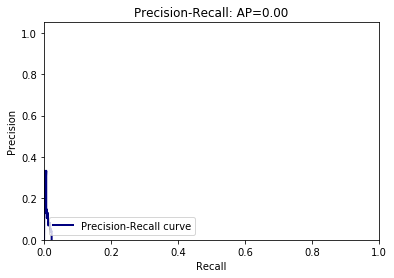

AP for Handgun and IoU threshold 0.85 = 0.0016


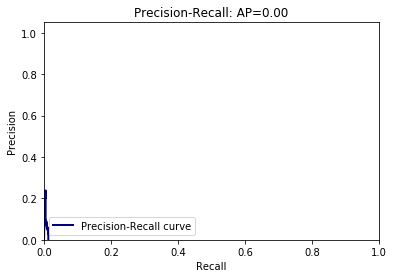

AP for Handgun and IoU threshold 0.90 = 0.0000


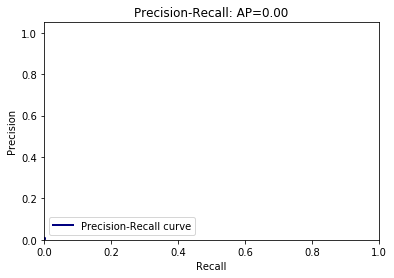

AP for Handgun and IoU threshold 0.95 = 0.0000


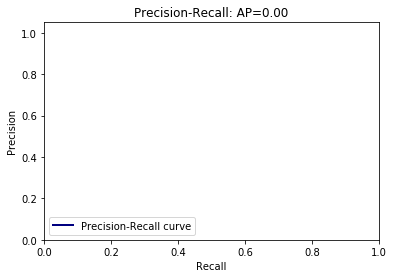

Mean AP for Handgun = 0.0393
AP for Rifle and IoU threshold 0.50 = 0.2304


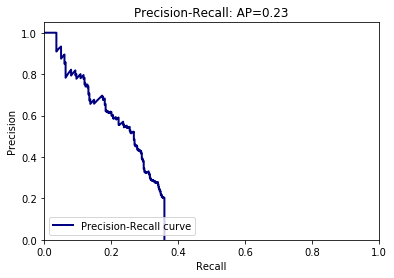

AP for Rifle and IoU threshold 0.55 = 0.2063


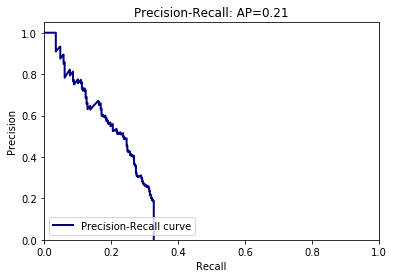

AP for Rifle and IoU threshold 0.60 = 0.1592


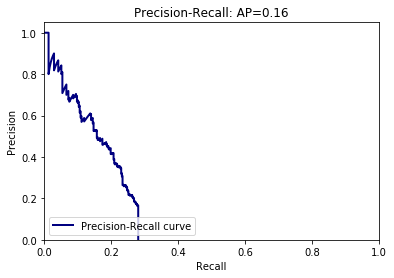

AP for Rifle and IoU threshold 0.65 = 0.1254


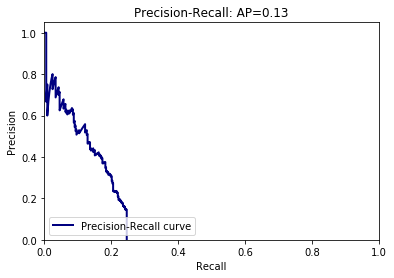

AP for Rifle and IoU threshold 0.70 = 0.0377


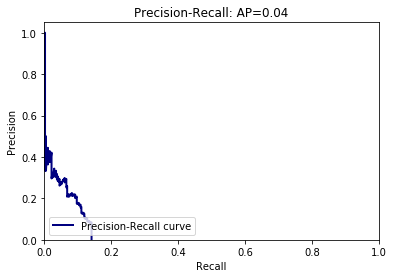

AP for Rifle and IoU threshold 0.75 = 0.0211


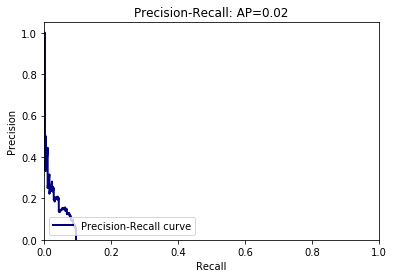

AP for Rifle and IoU threshold 0.80 = 0.0107


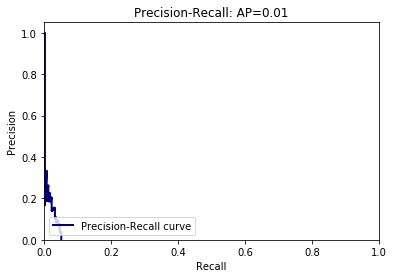

AP for Rifle and IoU threshold 0.85 = 0.0034


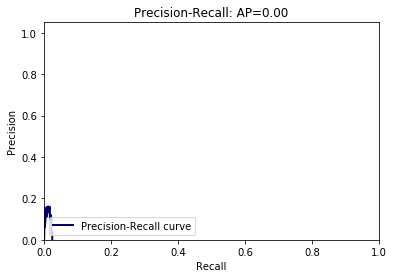

AP for Rifle and IoU threshold 0.90 = 0.0009


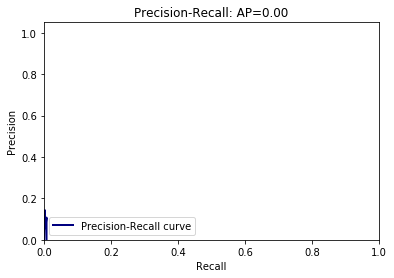

AP for Rifle and IoU threshold 0.95 = 0.0000


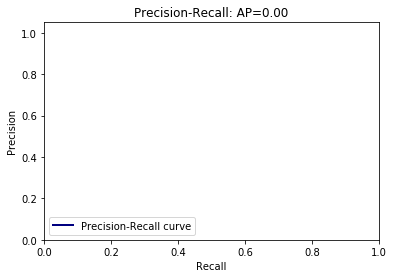

Mean AP for Rifle = 0.0795
Mean AP = 0.0594
~~~~~~~~
Results:
0.039
0.080
0.059


0.059421587117547844

In [31]:
compute_mean_average_precision_COCO2016(m0kunity_detections)

### Only lab - 1k unity

In [28]:
MODEL_NAME = 'weapons-onlylab-1kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.1221


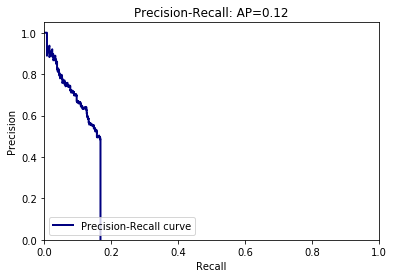

AP for Handgun and IoU threshold 0.55 = 0.0921


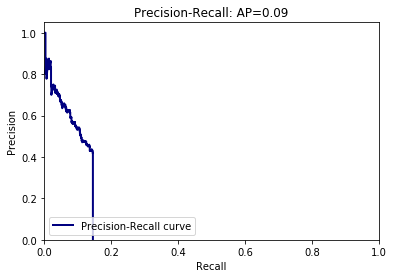

AP for Handgun and IoU threshold 0.60 = 0.0690


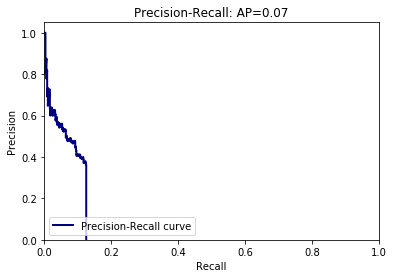

AP for Handgun and IoU threshold 0.65 = 0.0394


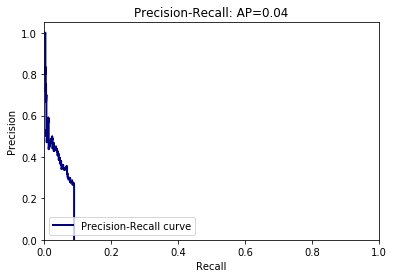

AP for Handgun and IoU threshold 0.70 = 0.0196


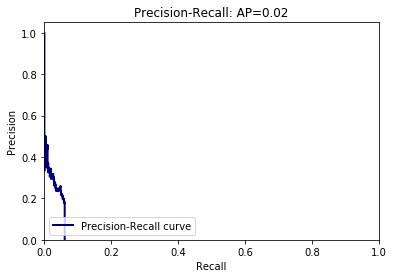

AP for Handgun and IoU threshold 0.75 = 0.0074


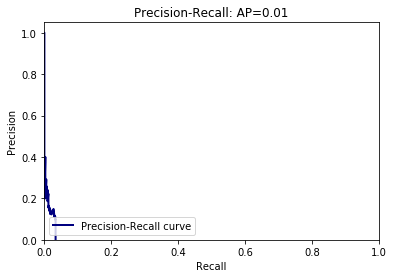

AP for Handgun and IoU threshold 0.80 = 0.0023


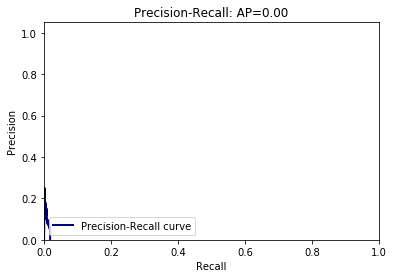

AP for Handgun and IoU threshold 0.85 = 0.0000


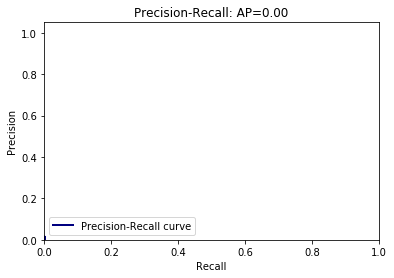

AP for Handgun and IoU threshold 0.90 = 0.0000


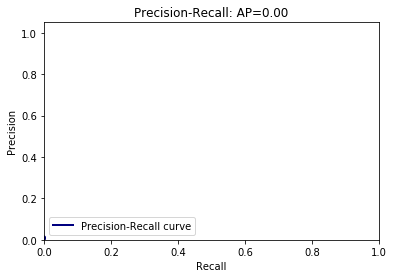

AP for Handgun and IoU threshold 0.95 = 0.0000


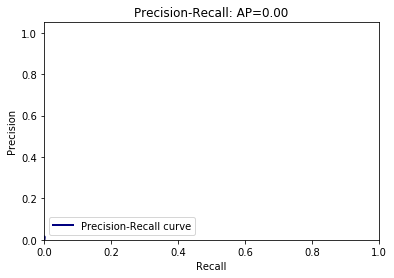

Mean AP for Handgun = 0.0352
AP for Rifle and IoU threshold 0.50 = 0.2381


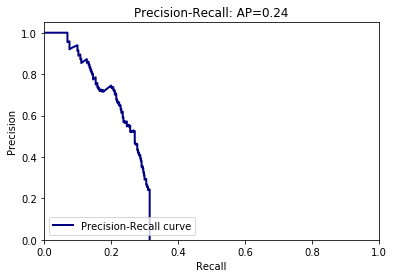

AP for Rifle and IoU threshold 0.55 = 0.2197


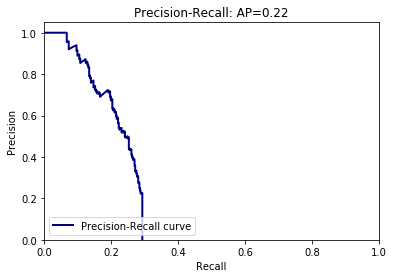

AP for Rifle and IoU threshold 0.60 = 0.1664


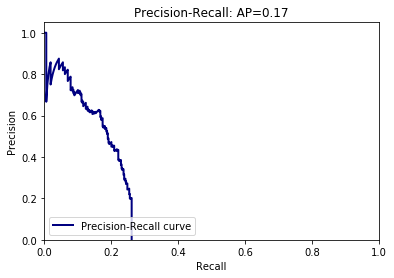

AP for Rifle and IoU threshold 0.65 = 0.1199


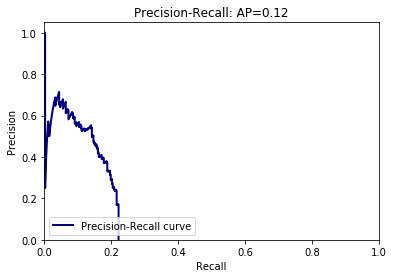

AP for Rifle and IoU threshold 0.70 = 0.0648


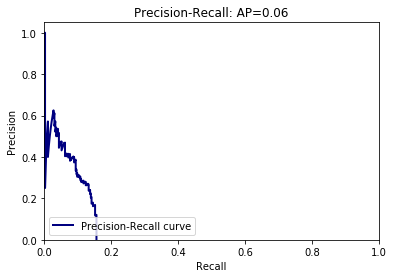

AP for Rifle and IoU threshold 0.75 = 0.0306


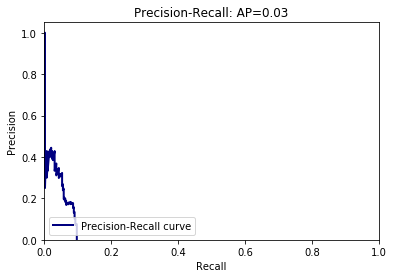

AP for Rifle and IoU threshold 0.80 = 0.0046


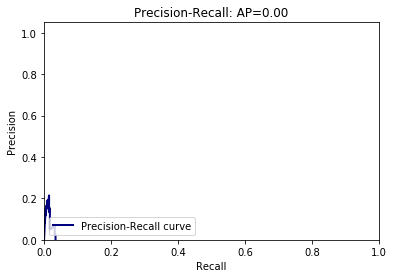

AP for Rifle and IoU threshold 0.85 = 0.0011


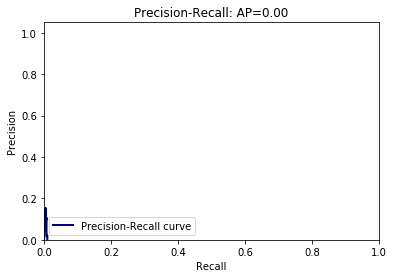

AP for Rifle and IoU threshold 0.90 = 0.0002


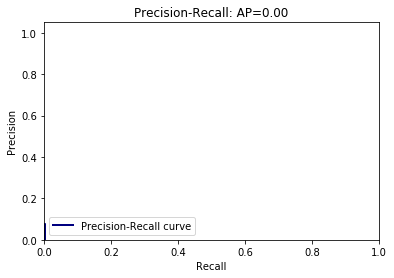

AP for Rifle and IoU threshold 0.95 = 0.0000


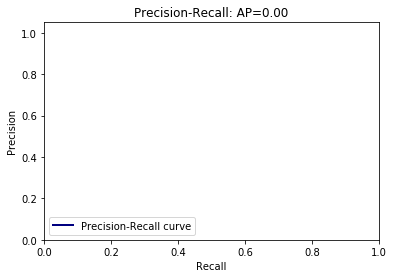

Mean AP for Rifle = 0.0845
Mean AP = 0.0599
~~~~~~~~
Results:
0.035
0.085
0.060


0.05987497492579773

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### Only lab - 2.5k unity

In [28]:
MODEL_NAME = 'weapons-onlylab-2.5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.0916


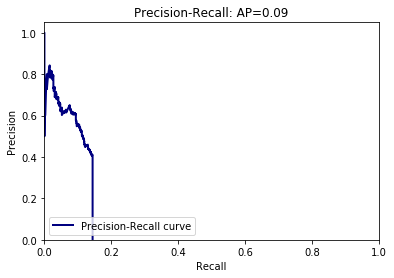

AP for Handgun and IoU threshold 0.55 = 0.0659


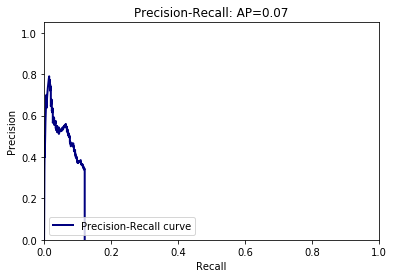

AP for Handgun and IoU threshold 0.60 = 0.0446


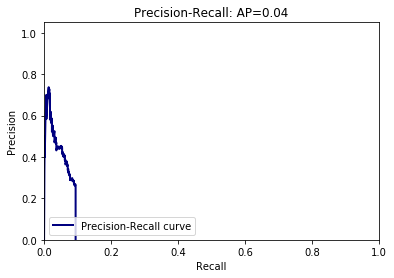

AP for Handgun and IoU threshold 0.65 = 0.0237


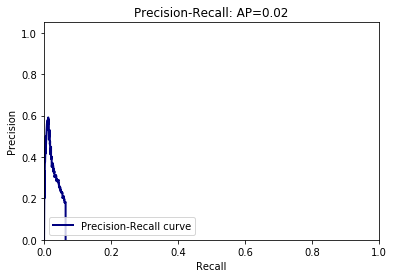

AP for Handgun and IoU threshold 0.70 = 0.0114


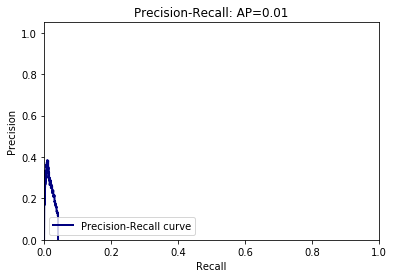

AP for Handgun and IoU threshold 0.75 = 0.0064


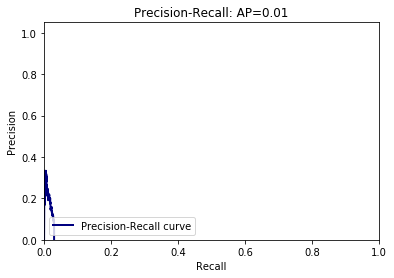

AP for Handgun and IoU threshold 0.80 = 0.0023


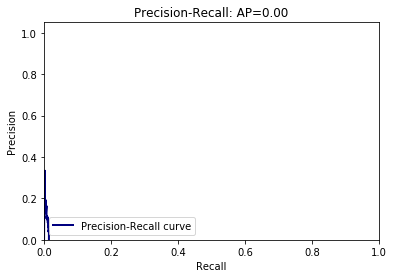

AP for Handgun and IoU threshold 0.85 = 0.0003


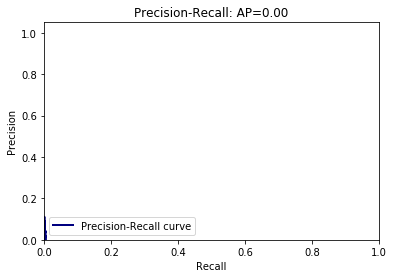

AP for Handgun and IoU threshold 0.90 = 0.0000


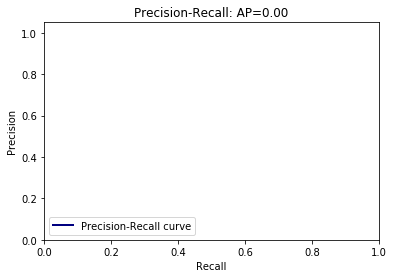

AP for Handgun and IoU threshold 0.95 = 0.0000


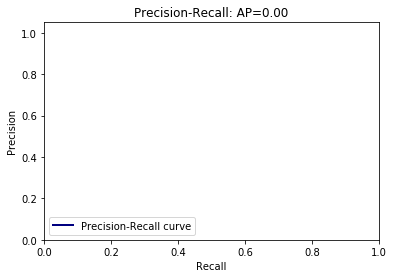

Mean AP for Handgun = 0.0246
AP for Rifle and IoU threshold 0.50 = 0.2347


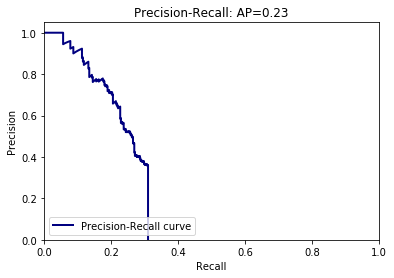

AP for Rifle and IoU threshold 0.55 = 0.2057


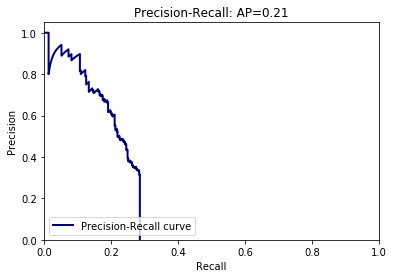

AP for Rifle and IoU threshold 0.60 = 0.1490


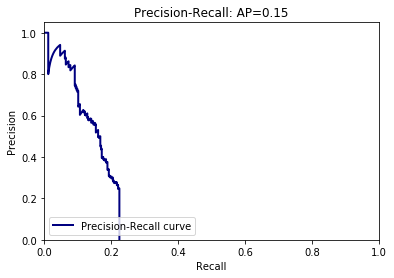

AP for Rifle and IoU threshold 0.65 = 0.1020


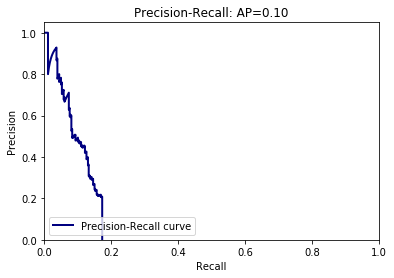

AP for Rifle and IoU threshold 0.70 = 0.0606


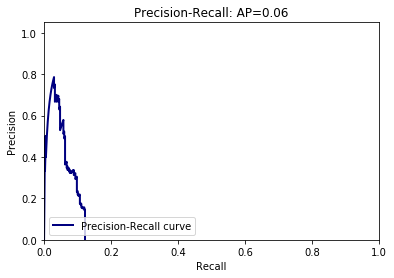

AP for Rifle and IoU threshold 0.75 = 0.0188


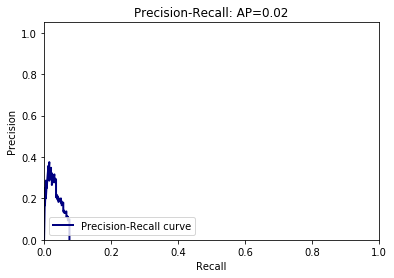

AP for Rifle and IoU threshold 0.80 = 0.0041


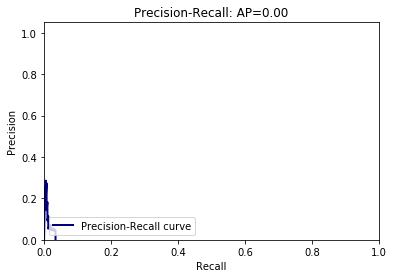

AP for Rifle and IoU threshold 0.85 = 0.0008


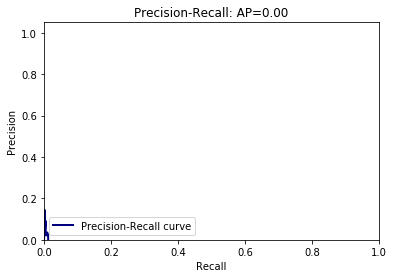

AP for Rifle and IoU threshold 0.90 = 0.0002


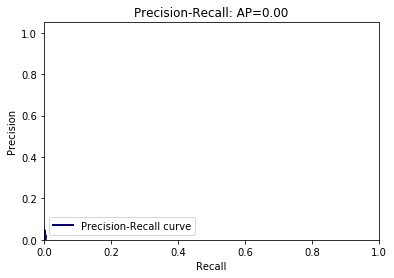

AP for Rifle and IoU threshold 0.95 = 0.0000


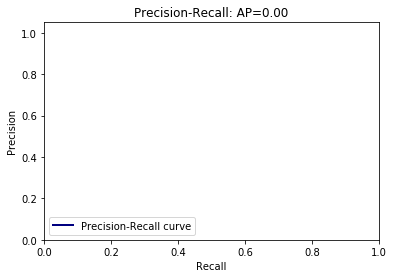

Mean AP for Rifle = 0.0776
Mean AP = 0.0511
~~~~~~~~
Results:
0.025
0.078
0.051


0.051115470568503116

In [29]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### Only lab - 5k unity

In [30]:
MODEL_NAME = 'weapons-onlylab-5kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.1054


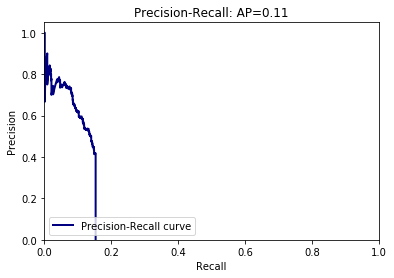

AP for Handgun and IoU threshold 0.55 = 0.0795


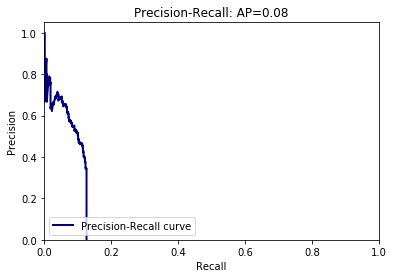

AP for Handgun and IoU threshold 0.60 = 0.0538


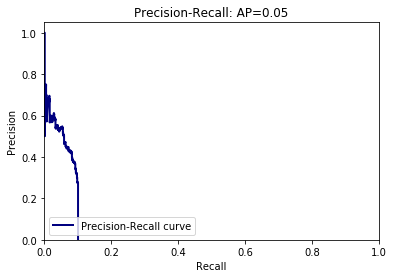

AP for Handgun and IoU threshold 0.65 = 0.0319


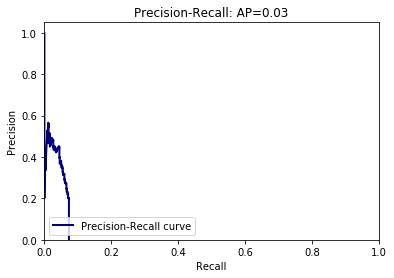

AP for Handgun and IoU threshold 0.70 = 0.0191


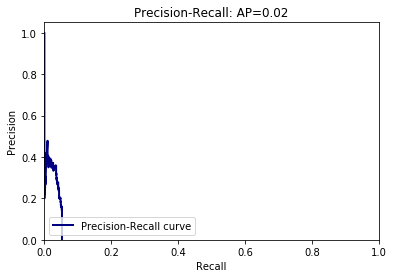

AP for Handgun and IoU threshold 0.75 = 0.0075


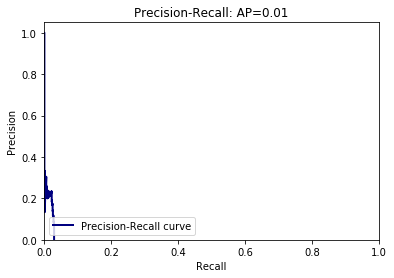

AP for Handgun and IoU threshold 0.80 = 0.0012


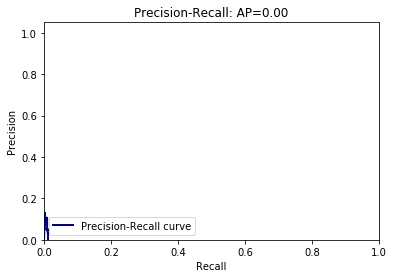

AP for Handgun and IoU threshold 0.85 = 0.0002


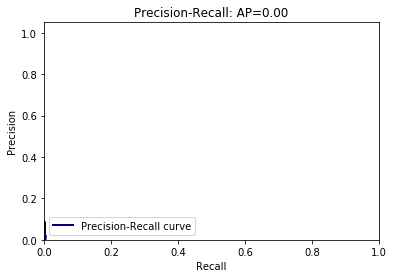

AP for Handgun and IoU threshold 0.90 = 0.0000


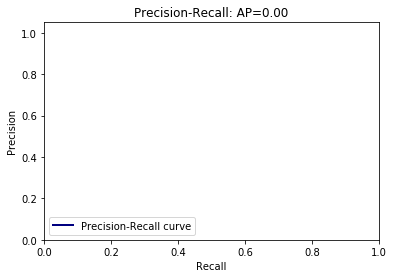

AP for Handgun and IoU threshold 0.95 = 0.0000


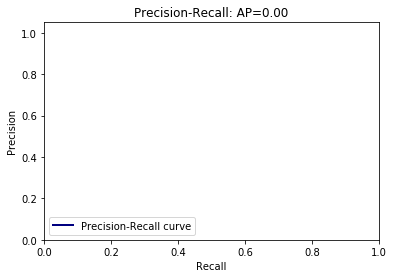

Mean AP for Handgun = 0.0299
AP for Rifle and IoU threshold 0.50 = 0.1319


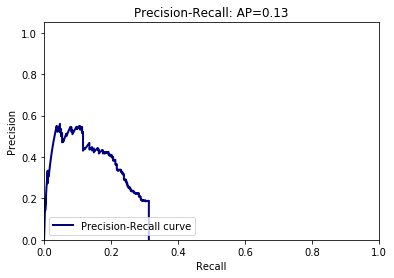

AP for Rifle and IoU threshold 0.55 = 0.1036


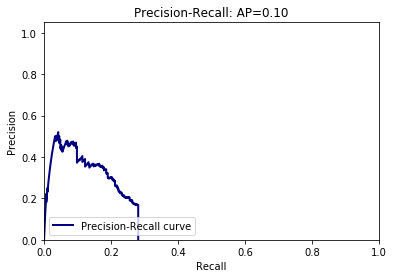

AP for Rifle and IoU threshold 0.60 = 0.0769


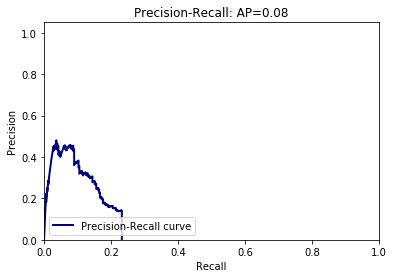

AP for Rifle and IoU threshold 0.65 = 0.0400


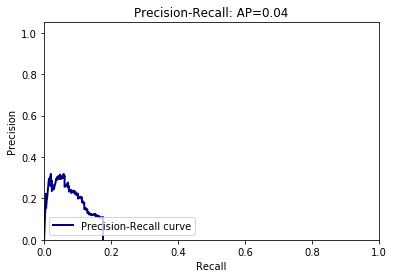

AP for Rifle and IoU threshold 0.70 = 0.0247


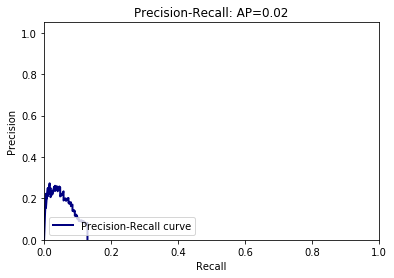

AP for Rifle and IoU threshold 0.75 = 0.0107


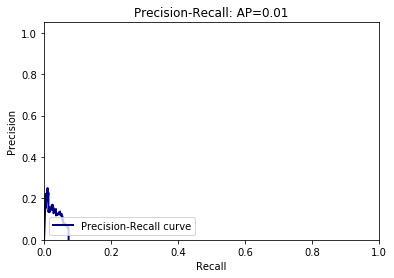

AP for Rifle and IoU threshold 0.80 = 0.0068


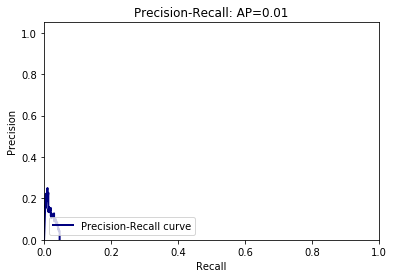

AP for Rifle and IoU threshold 0.85 = 0.0003


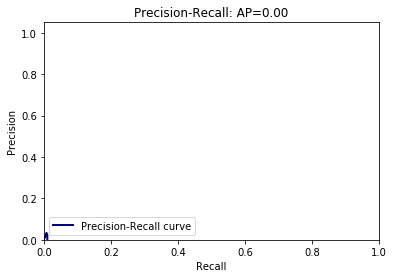

AP for Rifle and IoU threshold 0.90 = 0.0000


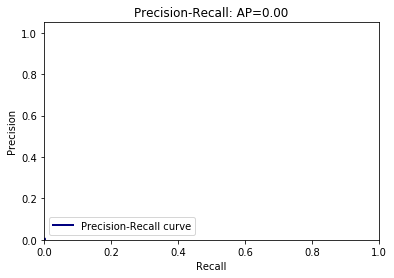

AP for Rifle and IoU threshold 0.95 = 0.0000


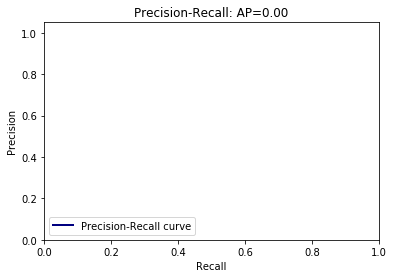

Mean AP for Rifle = 0.0395
Mean AP = 0.0347
~~~~~~~~
Results:
0.030
0.039
0.035


0.03467346703956805

In [31]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### All - 0k unity

In [32]:
MODEL_NAME = 'weapons-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

AP for Handgun and IoU threshold 0.50 = 0.1310


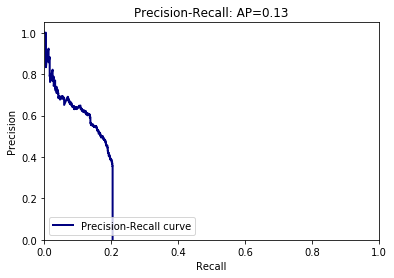

AP for Handgun and IoU threshold 0.55 = 0.0984


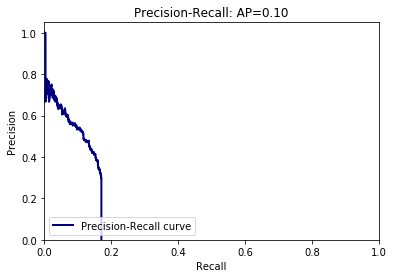

AP for Handgun and IoU threshold 0.60 = 0.0743


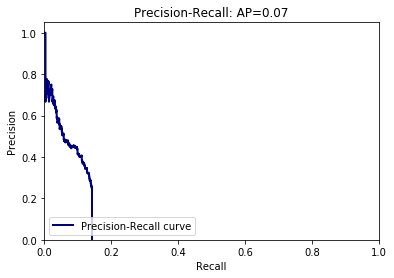

AP for Handgun and IoU threshold 0.65 = 0.0365


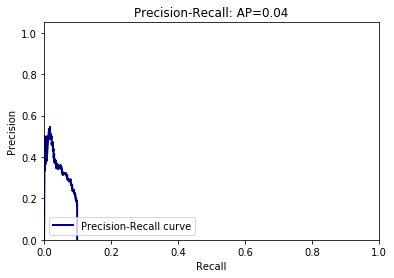

AP for Handgun and IoU threshold 0.70 = 0.0181


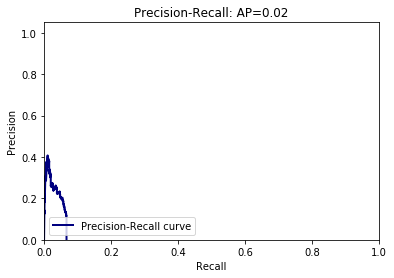

AP for Handgun and IoU threshold 0.75 = 0.0073


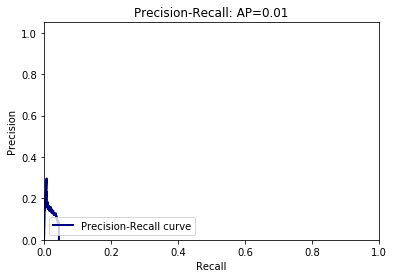

AP for Handgun and IoU threshold 0.80 = 0.0018


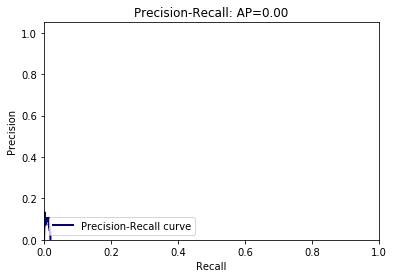

AP for Handgun and IoU threshold 0.85 = 0.0005


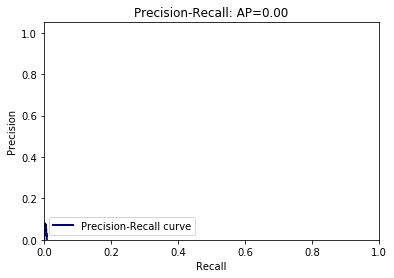

AP for Handgun and IoU threshold 0.90 = 0.0001


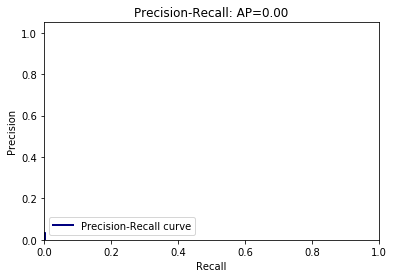

AP for Handgun and IoU threshold 0.95 = 0.0000


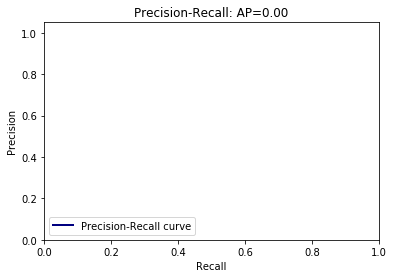

Mean AP for Handgun = 0.0368
AP for Rifle and IoU threshold 0.50 = 0.2012


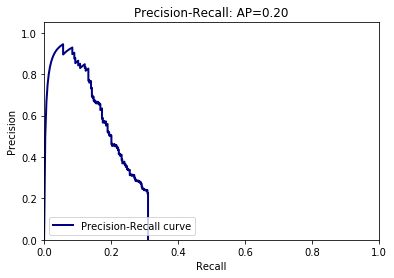

AP for Rifle and IoU threshold 0.55 = 0.1681


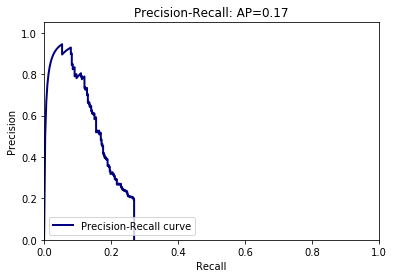

AP for Rifle and IoU threshold 0.60 = 0.1259


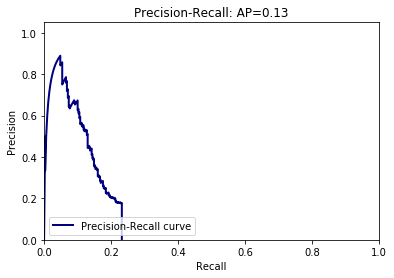

AP for Rifle and IoU threshold 0.65 = 0.0841


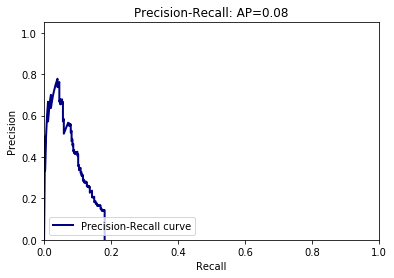

AP for Rifle and IoU threshold 0.70 = 0.0492


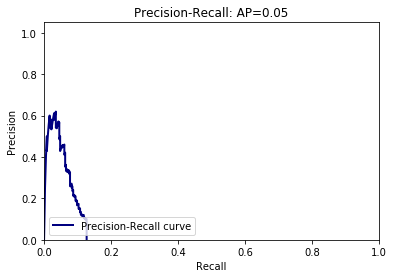

AP for Rifle and IoU threshold 0.75 = 0.0163


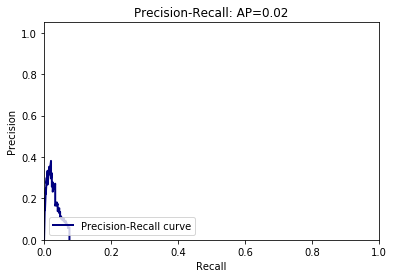

AP for Rifle and IoU threshold 0.80 = 0.0038


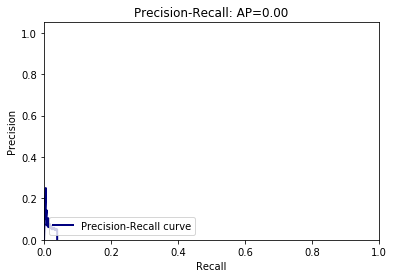

AP for Rifle and IoU threshold 0.85 = 0.0020


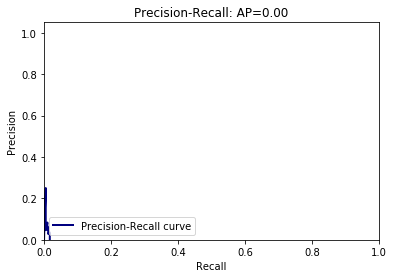

AP for Rifle and IoU threshold 0.90 = 0.0000


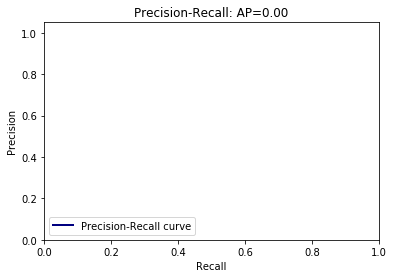

AP for Rifle and IoU threshold 0.95 = 0.0000


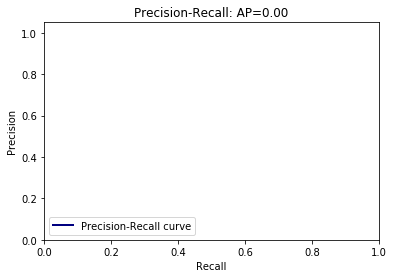

Mean AP for Rifle = 0.0650
Mean AP = 0.0509
~~~~~~~~
Results:
0.037
0.065
0.051


0.0509261574134562

In [33]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

### All - 1k unity

In [ ]:
MODEL_NAME = 'weapons-1kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m1kunity_detections = pickle.load(pickle_file)

In [ ]:
compute_mean_average_precision_COCO2016(m1kunity_detections)

## HR Detection

In [20]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'valid.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

In [1]:
# m0kunity_detections[0]

In [47]:
for detection in m0kunity_detections:
    res = compute_mean_average_precision_COCO2016_noplot([detection])
    if res[0][0] > 0.2:
        print(detection['file'], res)

Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_158.jpg ([0.4, 0.3], 0.35)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_38.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg ([0.65, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_157.jpg ([0.3, 0.0], 0.15)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_88.jpg ([0.5, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_93.jpg ([0.3, 0.0], 0.15)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_59.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_64.jpg ([0.3, 0.0], 0.15)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_61.jpg ([0.4, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_70.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_50.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg ([0.3, 0.5], 0.4)
Cam1-From09-23-00To10-03-25_Seg

In [ ]:
compute_mean_average_precision_COCO2016_noplot(m0kunity_detections[1])

In [33]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'validx4.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

In [34]:
for detection in m0kunity_detections:
    res = compute_mean_average_precision_COCO2016_noplot([detection])
    print(detection['file'], res)

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg ([0.4, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_156.jpg ([0.4, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_25.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_207.jpg ([0.2, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_71.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_143.jpg ([0.35, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_81.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_2_x264_frame_64.jpg ([0.6, nan], nan)


In [35]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'validx4-pre.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

In [36]:
for detection in m0kunity_detections:
    res = compute_mean_average_precision_COCO2016_noplot([detection])
    print(detection['file'], res)

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg ([0.65, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_156.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_25.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_207.jpg ([0.25, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_71.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_143.jpg ([0.35, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_81.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_2_x264_frame_64.jpg ([0.8, nan], nan)


In [37]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'validx4-imfdb.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

In [38]:
for detection in m0kunity_detections:
    res = compute_mean_average_precision_COCO2016_noplot([detection])
    print(detection['file'], res)

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg ([0.15, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_156.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_25.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_207.jpg ([0.2, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_71.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_143.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_81.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_2_x264_frame_64.jpg ([0.7, nan], nan)


In [28]:
MODELS_PATH = '/media/Shared/jossalgon/weapons/models/weapons2/noCam1'
MODEL_NAME = 'weapons-onlylab-0kunity'
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME, 'inference')
PICKLE_PATH = os.path.join(MODEL_PATH, 'validx4-imfdb-splited.pkl')

with open(PICKLE_PATH, 'rb') as pickle_file:
    m0kunity_detections = pickle.load(pickle_file)

In [30]:
for detection in m0kunity_detections:
    res = compute_mean_average_precision_COCO2016_noplot([detection])
    print(detection['file'], res)

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg ([0.6, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg ([0.15, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_156.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_25.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_207.jpg ([0.2, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_71.jpg ([0.8, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_143.jpg ([0.3, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_81.jpg ([0.7, nan], nan)
Cam1-From09-23-00To10-03-25_Segment_2_x264_frame_64.jpg ([0.6, nan], nan)


Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_41.jpg
NORMAL: 0.65
4X: 0.6
4X-PRE: 0.65
4X-IMFDB: 0.6
4X-IMFDB-split: 0.6

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_57.jpg
NORMAL: 0.8
4X: 0.7
4X-PRE: 0.8
4X-IMFDB: 0.8
4X-IMFDB-split: 0.8

Cam1-From09-23-00To10-03-25_Segment_0_x264_frame_95.jpg
NORMAL: 0.3
4X: 0.4
4X-PRE: 0.3
4X-IMFDB: 0.15
4X-IMFDB-split: 0.15
4X-IMFDB-split: 0.15

Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_156.jpg
NORMAL: 0.3
4X: 0.4
4X-PRE: 0.3
4X-IMFDB: 0.3
4X-IMFDB-split: 0.3

Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_25.jpg
NORMAL: 0.8
4X: 0.6
4X-PRE: 0.7
4X-IMFDB: 0.7
4X-IMFDB-split: 0.7

Cam1-From09-23-00To10-03-25_Segment_1_x264_frame_207.jpg
NORMAL: 0.5
4X: 0.2
4X-PRE: 0.25
4X-IMFDB: 0.2
4X-IMFDB-split: 0.2

Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_71.jpg
NORMAL: 0.7
4X: 0.8
4X-PRE: 0.7
4X-IMFDB: 0.7
4X-IMFDB-split: 0.8

Cam1-From09-23-00To10-03-25_Segment_5_x264_frame_143.jpg
NORMAL: 0.35
4X: 0.35
4X-PRE: 0.35
4X-IMFDB: 0.3
4X-IMFDB-split: 0.3

Cam1-From09-23-00To10-03-25_Segment_4_x264_frame_81.jpg
NORMAL: 0.7
4X: 0.7
4X-PRE: 0.7
4X-IMFDB: 0.7
4X-IMFDB-split: 0.7

Cam1-From09-23-00To10-03-25_Segment_2_x264_frame_64.jpg
NORMAL: 0.7
4X: 0.6
4X-PRE: 0.8
4X-IMFDB: 0.7
4X-IMFDB-split: 0.6